In [7]:
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns
from pathlib import Path
from collections import defaultdict
import math
import glob
from itertools import product
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score
from scipy.stats import pointbiserialr

# ============================================================================
# CONFIGURATION: Specify models and tests to analyze
# ============================================================================

# The most recent json file in capabilities_test_logs/ for each model/test pair
# defined below will be loaded.

MODELS = [
    "llama-3.1-8b-instruct",
    "llama-3.3-70b-instruct"
]

TESTS = [
    "PopMC",
    "TriviaMC",
    # "SimpleMC",
]

FONT_SIZE = 18  # Font size for plots


# Set style for better-looking plots
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 8)

# Font size configuration
plt.rcParams['font.size'] = FONT_SIZE
plt.rcParams['axes.labelsize'] = FONT_SIZE
plt.rcParams['axes.titlesize'] = FONT_SIZE
plt.rcParams['xtick.labelsize'] = FONT_SIZE
plt.rcParams['ytick.labelsize'] = FONT_SIZE
plt.rcParams['legend.fontsize'] = FONT_SIZE
plt.rcParams['figure.titlesize'] = FONT_SIZE + 2  # Slightly larger for suptitle


In [8]:
# Helper function to organize data into model x test grid and add labels
def create_model_test_grid(all_dfs, MODELS, TESTS):
    """
    Organize all_dfs into a model x test grid structure.
    Returns: (grid_data, available_models, available_tests)
    where grid_data is a dict: grid_data[model][test] = df
    """
    grid_data = {}
    available_models = []
    available_tests = []
    
    for model in MODELS:
        grid_data[model] = {}
        for test in TESTS:
            key = f"{model}_{test}"
            if key in all_dfs:
                grid_data[model][test] = all_dfs[key]
                if model not in available_models:
                    available_models.append(model)
                if test not in available_tests:
                    available_tests.append(test)
    
    return grid_data, available_models, available_tests

def add_model_test_labels(fig, axes, available_models, available_tests, n_rows, n_cols):
    """
    Add model names on the left (rotated 90 degrees) and test names on top.
    """
    # Handle axes shape
    if hasattr(axes, 'ndim'):
        if axes.ndim == 1:
            if n_rows == 1:
                axes = axes.reshape(1, -1)
            else:
                axes = axes.reshape(-1, 1)
    elif n_rows == 1 and n_cols == 1:
        # Single subplot case
        pass
    
    # Add model names on the left (rotated 90 degrees)
    if n_rows > 0:
        row_height = 1.0 / n_rows
        for row_idx, model in enumerate(available_models):
            row_center_y = 1.0 - (row_idx + 0.5) * row_height
            fig.text(0.04, row_center_y, model, rotation=90, 
                    ha='center', va='center', fontsize=FONT_SIZE, 
                    fontweight='bold')
    
    # Add test names on top (horizontal)
    if n_cols > 0:
        col_width = 1.0 / n_cols
        for col_idx, test in enumerate(available_tests):
            col_center_x = (col_idx + 0.5) * col_width
            fig.text(col_center_x, 0.92, test, 
                    ha='center', va='top', fontsize=FONT_SIZE, 
                    fontweight='bold')



In [9]:
def load_test_data(file_path):
    """Load a test data JSON file."""
    with open(file_path, 'r') as f:
        return json.load(f)

def extract_probability_data(data):
    """
    Extract probability data from test results.
    Returns a list of dictionaries with analysis data for each question.
    """
    results = []
    
    for q_id, res_info in data.get("results", {}).items():
        question = res_info.get("question", {})
        probs = res_info.get("probs", {})
        correct_answer = question.get("correct_answer")
        subject_answer = res_info.get("subject_answer")
        is_correct = res_info.get("is_correct", False)
        
        if not probs or not correct_answer:
            continue
            
        # Get probability for correct answer
        prob_correct = probs.get(correct_answer, 0.0)
        
        # Get probability for model's chosen answer
        prob_chosen = probs.get(subject_answer, 0.0) if subject_answer else 0.0
        
        # Get all probabilities sorted
        sorted_probs = sorted(probs.items(), key=lambda x: x[1], reverse=True)
        
        # Find rank of correct answer (1-indexed)
        correct_rank = None
        for rank, (option, prob) in enumerate(sorted_probs, 1):
            if option == correct_answer:
                correct_rank = rank
                break
        
        # Calculate entropy (uncertainty measure)
        prob_values = [p for p in probs.values() if p > 1e-9]
        if len(prob_values) > 1:
            entropy = -sum(p * math.log2(p) for p in prob_values if p > 1e-9)
        else:
            entropy = 0.0
        
        # Calculate confidence (max probability)
        max_prob = max(probs.values()) if probs else 0.0
        
        results.append({
            'question_id': q_id,
            'correct_answer': correct_answer,
            'subject_answer': subject_answer,
            'is_correct': is_correct,
            'prob_correct': prob_correct,
            'prob_chosen': prob_chosen,
            'correct_rank': correct_rank,
            'max_prob': max_prob,
            'entropy': entropy,
            'prob_correct_rank': prob_correct,
            'all_probs': probs,
            'question_text': question.get("question", ""),
            'dataset': data.get("subject_id", "").split("_")[-1] if "_" in data.get("subject_id", "") else "",
        })
    
    return results


    # Load all test files for specified models and tests
all_data = {}
all_dfs = {}

print("=" * 80)
print("Loading data for all model/test combinations...")
print("=" * 80)

for model, test in product(MODELS, TESTS):
    # Find the matching file
    # Pattern matches: {model}_{test}_500_{timestamp}_test_data.json
    pattern = f"../capabilities_test_logs/{model}_{test}_500_*_test_data.json"
    matching_files = glob.glob(pattern)
    
    if not matching_files:
        print(f"⚠️  WARNING: No file found for {model} - {test}")
        continue
    
    # Use the most recent file if multiple (by filename/timestamp)
    # NOTE: This selects the file with the highest timestamp, which may be incomplete.
    # If you have incomplete runs, you may want to manually select the complete one.
    test_file = sorted(matching_files)[-1]
    key = f"{model}_{test}"
    
    try:
        data = load_test_data(test_file)
        # Count total questions in the JSON file
        total_questions_in_file = len(data.get("results", {}))
        print(f"  📊 File: {test_file.split('/')[-1]}")
        print(f"  📊 Total questions in JSON file: {total_questions_in_file}")
        prob_data = extract_probability_data(data)
        
        # Add model and test info to each record
        for item in prob_data:
            item['model'] = model
            item['test'] = test
            item['model_test'] = key
        
        df = pd.DataFrame(prob_data)
        
        # Compute max_logprob from max_prob (log of maximum probability)
        # Use a small epsilon to avoid log(0)
        df['max_logprob'] = df['max_prob'].apply(lambda p: math.log(max(p, 1e-10)))
        
        all_data[key] = data
        all_dfs[key] = df
        
        print(f"✓ Loaded {model} - {test}: {len(df)} questions, accuracy: {data.get('accuracy', 'N/A')}")
    except Exception as e:
        print(f"✗ Error loading {model} - {test}: {e}")

print(f"\n{'=' * 80}")
print(f"Successfully loaded {len(all_dfs)} model/test combinations")
print(f"{'=' * 80}\n")

# Create combined dataframe for analysis
if all_dfs:
    combined_df = pd.concat(all_dfs.values(), ignore_index=True)
    print("Combined dataset summary:")
    print(f"  Total questions: {len(combined_df)}")
    print(f"  Models: {combined_df['model'].unique().tolist()}")
    print(f"  Tests: {combined_df['test'].unique().tolist()}")
    print(f"\nFirst few rows of combined data:")
    combined_df.head()
else:
    print("No data loaded! Please check your MODEL and TEST configurations.")


Loading data for all model/test combinations...
  📊 File: llama-3.1-8b-instruct_PopMC_500_1762723967_test_data.json
  📊 Total questions in JSON file: 500
✓ Loaded llama-3.1-8b-instruct - PopMC: 500 questions, accuracy: 0.614
  📊 File: llama-3.1-8b-instruct_TriviaMC_500_1763152932_test_data.json
  📊 Total questions in JSON file: 500
✓ Loaded llama-3.1-8b-instruct - TriviaMC: 500 questions, accuracy: 0.772
  📊 File: llama-3.3-70b-instruct_PopMC_500_1763248562_test_data.json
  📊 Total questions in JSON file: 500
✓ Loaded llama-3.3-70b-instruct - PopMC: 500 questions, accuracy: 0.736
  📊 File: llama-3.3-70b-instruct_TriviaMC_500_1762809440_test_data.json
  📊 Total questions in JSON file: 500
✓ Loaded llama-3.3-70b-instruct - TriviaMC: 495 questions, accuracy: 0.894

Successfully loaded 4 model/test combinations

Combined dataset summary:
  Total questions: 1995
  Models: ['llama-3.1-8b-instruct', 'llama-3.3-70b-instruct']
  Tests: ['PopMC', 'TriviaMC']

First few rows of combined data:


In [56]:
# Basic statistics for each model/test combination
print("=" * 80)
print("BASIC STATISTICS - Side-by-side comparison")
print("=" * 80)

stats_list = []
for key, df in all_dfs.items():
    model, test = key.split('_', 1) if '_' in key else (key, '')
    stats = {
        'Model': model,
        'Test': test,
        'Accuracy': df['is_correct'].mean(),
        'Mean P(correct)': df['prob_correct'].mean(),
        'Mean P(chosen)': df['prob_chosen'].mean(),
        'Mean Entropy': df['entropy'].mean(),
        '% Correct rank #1': (df['correct_rank'] == 1).mean() * 100,
        '% Correct in top 2': (df['correct_rank'] <= 2).mean() * 100,
        'N Questions': len(df),
    }
    stats_list.append(stats)

stats_df = pd.DataFrame(stats_list)
print("\nSummary Statistics Table:")
print(stats_df.to_string(index=False))

# Also show detailed stats for each combination
print("\n" + "=" * 80)
print("DETAILED STATISTICS BY MODEL/TEST")
print("=" * 80)
for key, df in all_dfs.items():
    model, test = key.split('_', 1) if '_' in key else (key, '')
    print(f"\n--- {model} - {test} ---")
    print(f"Overall Accuracy: {df['is_correct'].mean():.3f}")
    print(f"Mean probability assigned to correct answer: {df['prob_correct'].mean():.3f}")
    print(f"Mean probability assigned to chosen answer: {df['prob_chosen'].mean():.3f}")
    print(f"Mean entropy: {df['entropy'].mean():.3f}")
    print(f"Percentage where correct answer has highest probability: {(df['correct_rank'] == 1).mean() * 100:.1f}%")
    print(f"Percentage where correct answer is in top 2: {(df['correct_rank'] <= 2).mean() * 100:.1f}%")
    print(f"Correct answer rank distribution:")
    print(df['correct_rank'].value_counts().sort_index().to_string())


BASIC STATISTICS - Side-by-side comparison

Summary Statistics Table:
                 Model     Test  Accuracy  Mean P(correct)  Mean P(chosen)  Mean Entropy  % Correct rank #1  % Correct in top 2  N Questions
 llama-3.1-8b-instruct    PopMC  0.614000         0.597865        0.825543      0.640983          61.400000           80.800000          500
 llama-3.1-8b-instruct TriviaMC  0.772000         0.758434        0.915253      0.317972          77.200000           86.400000          500
llama-3.3-70b-instruct    PopMC  0.736000         0.737523        0.957772      0.144944          73.600000           88.800000          500
llama-3.3-70b-instruct TriviaMC  0.894949         0.895861        0.982356      0.059939          89.494949           95.151515          495

DETAILED STATISTICS BY MODEL/TEST

--- llama-3.1-8b-instruct - PopMC ---
Overall Accuracy: 0.614
Mean probability assigned to correct answer: 0.598
Mean probability assigned to chosen answer: 0.826
Mean entropy: 0.641
Percen

In [4]:
# Side-by-side comparison plots for each model/test combination
n_combos = len(all_dfs)
if n_combos == 0:
    print("No data to plot!")
else:
    # Organize data into model x test grid
    grid_data, available_models, available_tests = create_model_test_grid(all_dfs, MODELS, TESTS)
    n_rows = len(available_models)
    n_cols = len(available_tests)
    
    # Plot 1: Distribution of P(correct) by response correctness
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(14 * n_cols, 6 * n_rows))
    if n_rows == 1:
        axes = axes.reshape(1, -1) if n_cols > 1 else axes.reshape(1, 1)
    elif n_cols == 1:
        axes = axes.reshape(-1, 1)
    
    fig.suptitle('Distribution of P(correct) by Response Correctness', fontsize=FONT_SIZE + 2, fontweight='bold', y=0.99)
    
    for row_idx, model in enumerate(available_models):
        for col_idx, test in enumerate(available_tests):
            ax = axes[row_idx, col_idx]
            if model in grid_data and test in grid_data[model]:
                df = grid_data[model][test]
                correct_probs = df[df['is_correct']]['prob_correct']
                incorrect_probs = df[~df['is_correct']]['prob_correct']
                ax.hist(correct_probs, bins=30, alpha=0.6, label='Correct responses', color='green')
                ax.hist(incorrect_probs, bins=30, alpha=0.6, label='Incorrect responses', color='red')
                ax.set_xlabel('Probability assigned to correct answer')
                ax.set_ylabel('Frequency')
                ax.set_title(f'Mean (correct): {correct_probs.mean():.3f}, Mean (incorrect): {incorrect_probs.mean():.3f}')
                ax.legend()
                ax.axvline(correct_probs.mean(), color='green', linestyle='--', alpha=0.7)
                ax.axvline(incorrect_probs.mean(), color='red', linestyle='--', alpha=0.7)
            else:
                ax.set_visible(False)
    
    # Add model and test labels
    add_model_test_labels(fig, axes, available_models, available_tests, n_rows, n_cols)
    
    plt.tight_layout(rect=[0.05, 0, 1, 0.95])
    plt.show()
    
    # Plot 2: Distribution of P(chosen) by response correctness
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(14 * n_cols, 6 * n_rows))
    if n_rows == 1:
        axes = axes.reshape(1, -1) if n_cols > 1 else axes.reshape(1, 1)
    elif n_cols == 1:
        axes = axes.reshape(-1, 1)
    
    fig.suptitle('Distribution of P(chosen) by Response Correctness', fontsize=FONT_SIZE + 2, fontweight='bold')
    
    for row_idx, model in enumerate(available_models):
        for col_idx, test in enumerate(available_tests):
            ax = axes[row_idx, col_idx]
            if model in grid_data and test in grid_data[model]:
                df = grid_data[model][test]
                correct_chosen = df[df['is_correct']]['prob_chosen']
                incorrect_chosen = df[~df['is_correct']]['prob_chosen']
                ax.hist(correct_chosen, bins=30, alpha=0.6, label='Correct responses', color='green')
                ax.hist(incorrect_chosen, bins=30, alpha=0.6, label='Incorrect responses', color='red')
                ax.set_xlabel('Probability assigned to chosen answer')
                ax.set_ylabel('Frequency')
                ax.set_title('')
                ax.legend()
            else:
                ax.set_visible(False)
    
    # Add model and test labels
    add_model_test_labels(fig, axes, available_models, available_tests, n_rows, n_cols)
    
    plt.tight_layout(rect=[0.05, 0, 1, 0.95])
    plt.show()
    
    # Plot 3: Entropy distribution
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(14 * n_cols, 6 * n_rows))
    if n_rows == 1:
        axes = axes.reshape(1, -1) if n_cols > 1 else axes.reshape(1, 1)
    elif n_cols == 1:
        axes = axes.reshape(-1, 1)
    
    fig.suptitle('Distribution of Entropy by Response Correctness', fontsize=FONT_SIZE + 2, fontweight='bold')
    
    for row_idx, model in enumerate(available_models):
        for col_idx, test in enumerate(available_tests):
            ax = axes[row_idx, col_idx]
            if model in grid_data and test in grid_data[model]:
                df = grid_data[model][test]
                correct_entropy = df[df['is_correct']]['entropy']
                incorrect_entropy = df[~df['is_correct']]['entropy']
                ax.hist(correct_entropy, bins=30, alpha=0.6, label='Correct responses', color='green')
                ax.hist(incorrect_entropy, bins=30, alpha=0.6, label='Incorrect responses', color='red')
                ax.set_xlabel('Entropy (uncertainty)')
                ax.set_ylabel('Frequency')
                ax.set_title('')
                ax.legend()
            else:
                ax.set_visible(False)
    
    # Add model and test labels
    add_model_test_labels(fig, axes, available_models, available_tests, n_rows, n_cols)
    
    plt.tight_layout(rect=[0.05, 0, 1, 0.95])
    plt.show()
    
    # Plot 4: Correct answer rank distribution
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(14 * n_cols, 6 * n_rows))
    if n_rows == 1:
        axes = axes.reshape(1, -1) if n_cols > 1 else axes.reshape(1, 1)
    elif n_cols == 1:
        axes = axes.reshape(-1, 1)
    
    fig.suptitle('Distribution of Correct Answer Ranks', fontsize=FONT_SIZE + 2, fontweight='bold')
    
    for row_idx, model in enumerate(available_models):
        for col_idx, test in enumerate(available_tests):
            ax = axes[row_idx, col_idx]
            if model in grid_data and test in grid_data[model]:
                df = grid_data[model][test]
                rank_counts = df['correct_rank'].value_counts().sort_index()
                ax.bar(rank_counts.index, rank_counts.values, color='steelblue')
                ax.set_xlabel('Rank of correct answer (1 = highest prob)')
                ax.set_ylabel('Frequency')
                ax.set_title('')
                ax.set_xticks([1, 2, 3, 4])
            else:
                ax.set_visible(False)
    
    # Add model and test labels
    add_model_test_labels(fig, axes, available_models, available_tests, n_rows, n_cols)
    
    plt.tight_layout(rect=[0.05, 0, 1, 0.95])
    plt.show()


NameError: name 'create_model_test_grid' is not defined

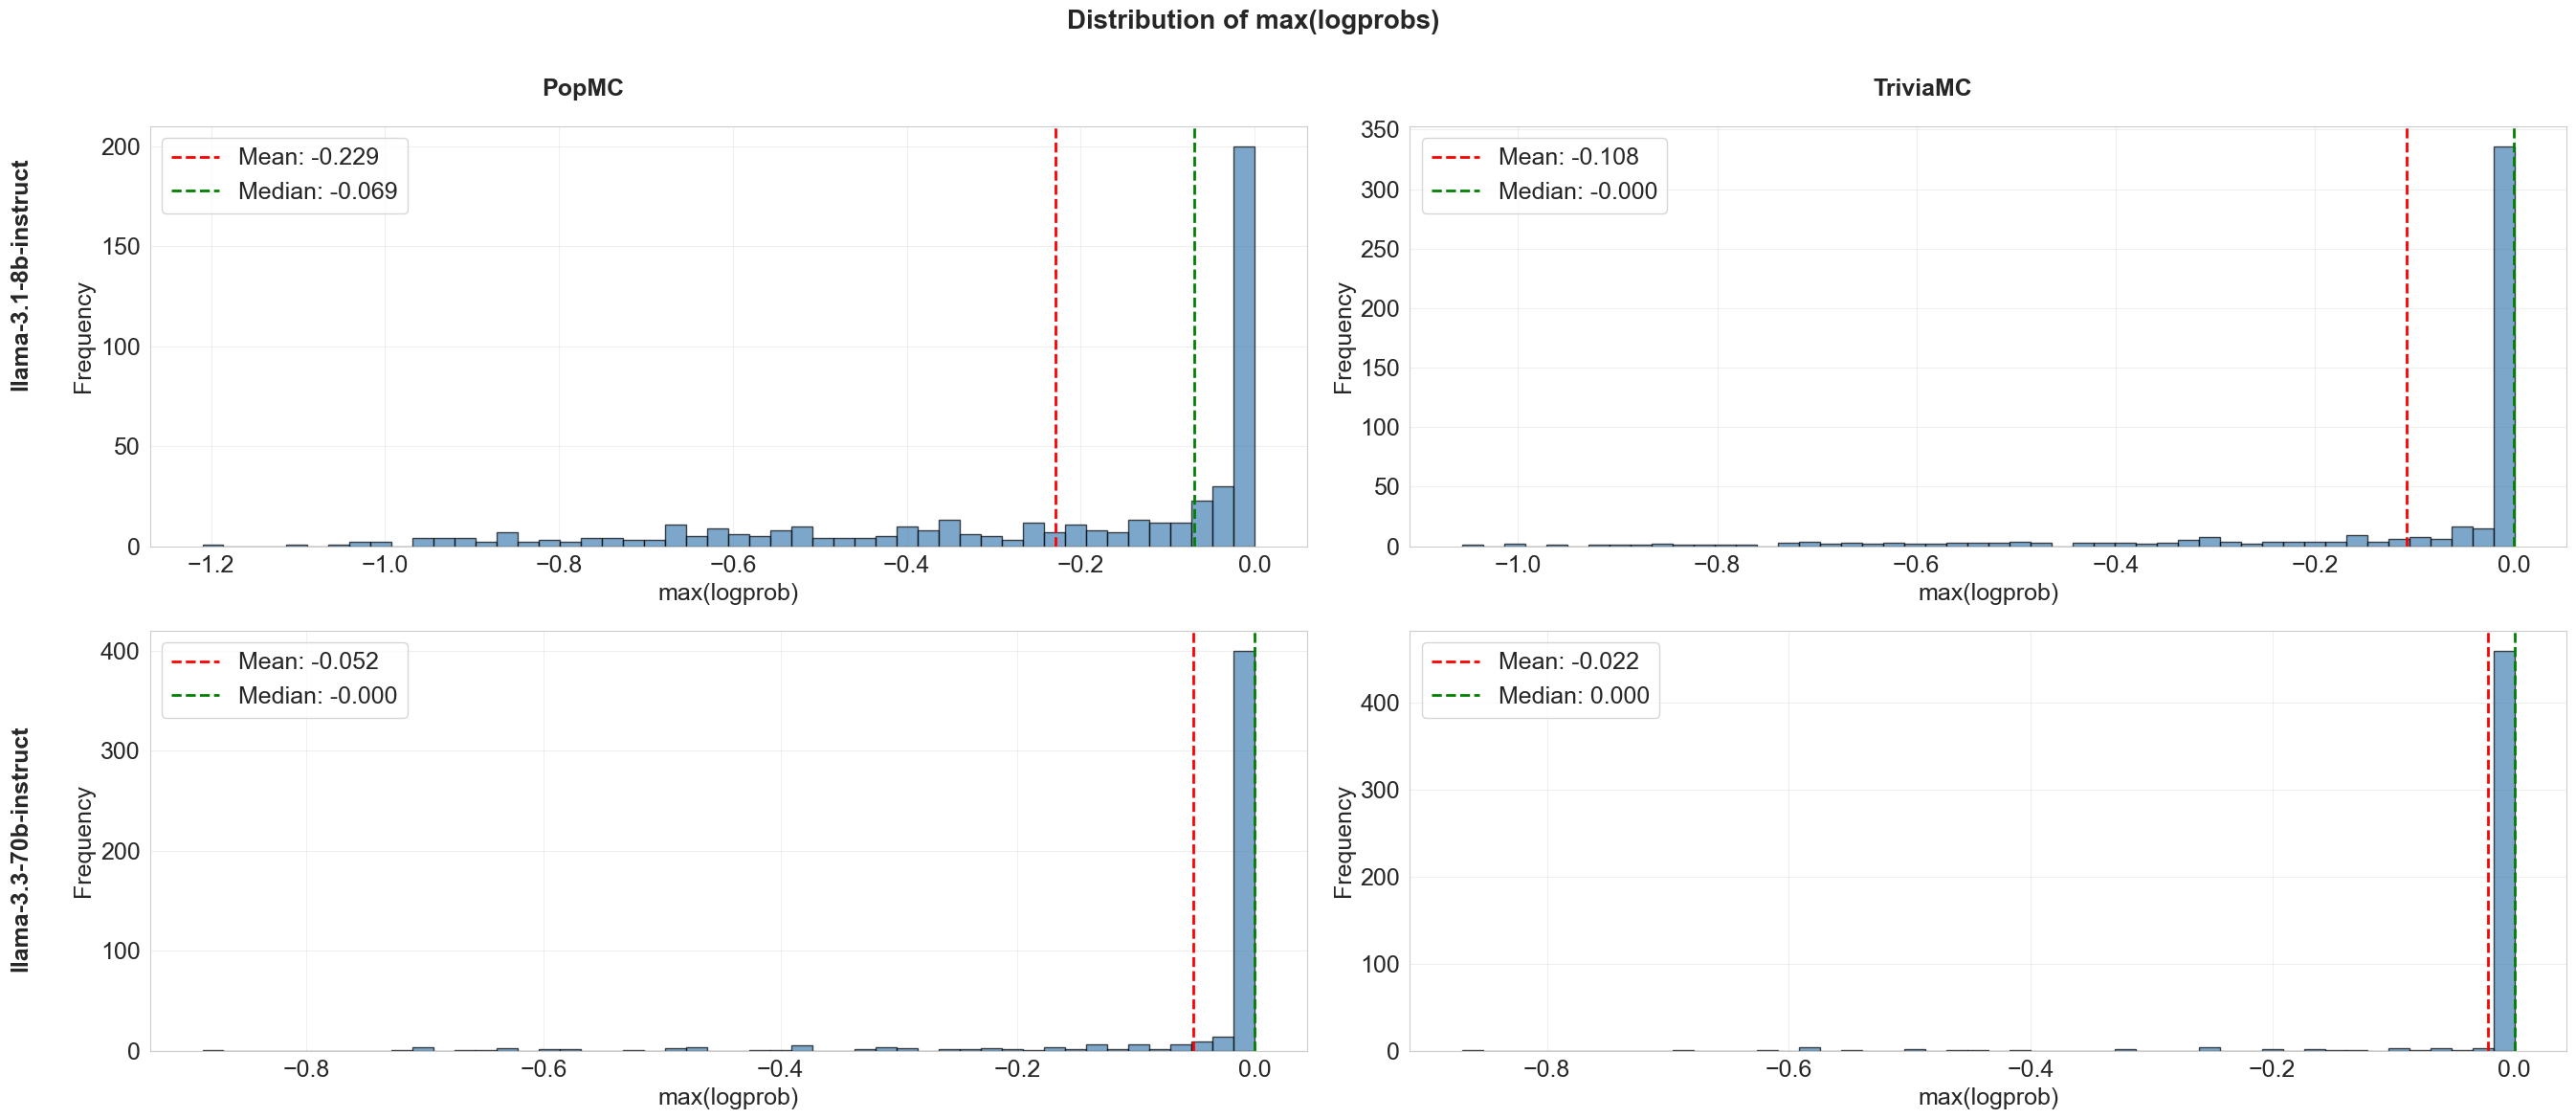

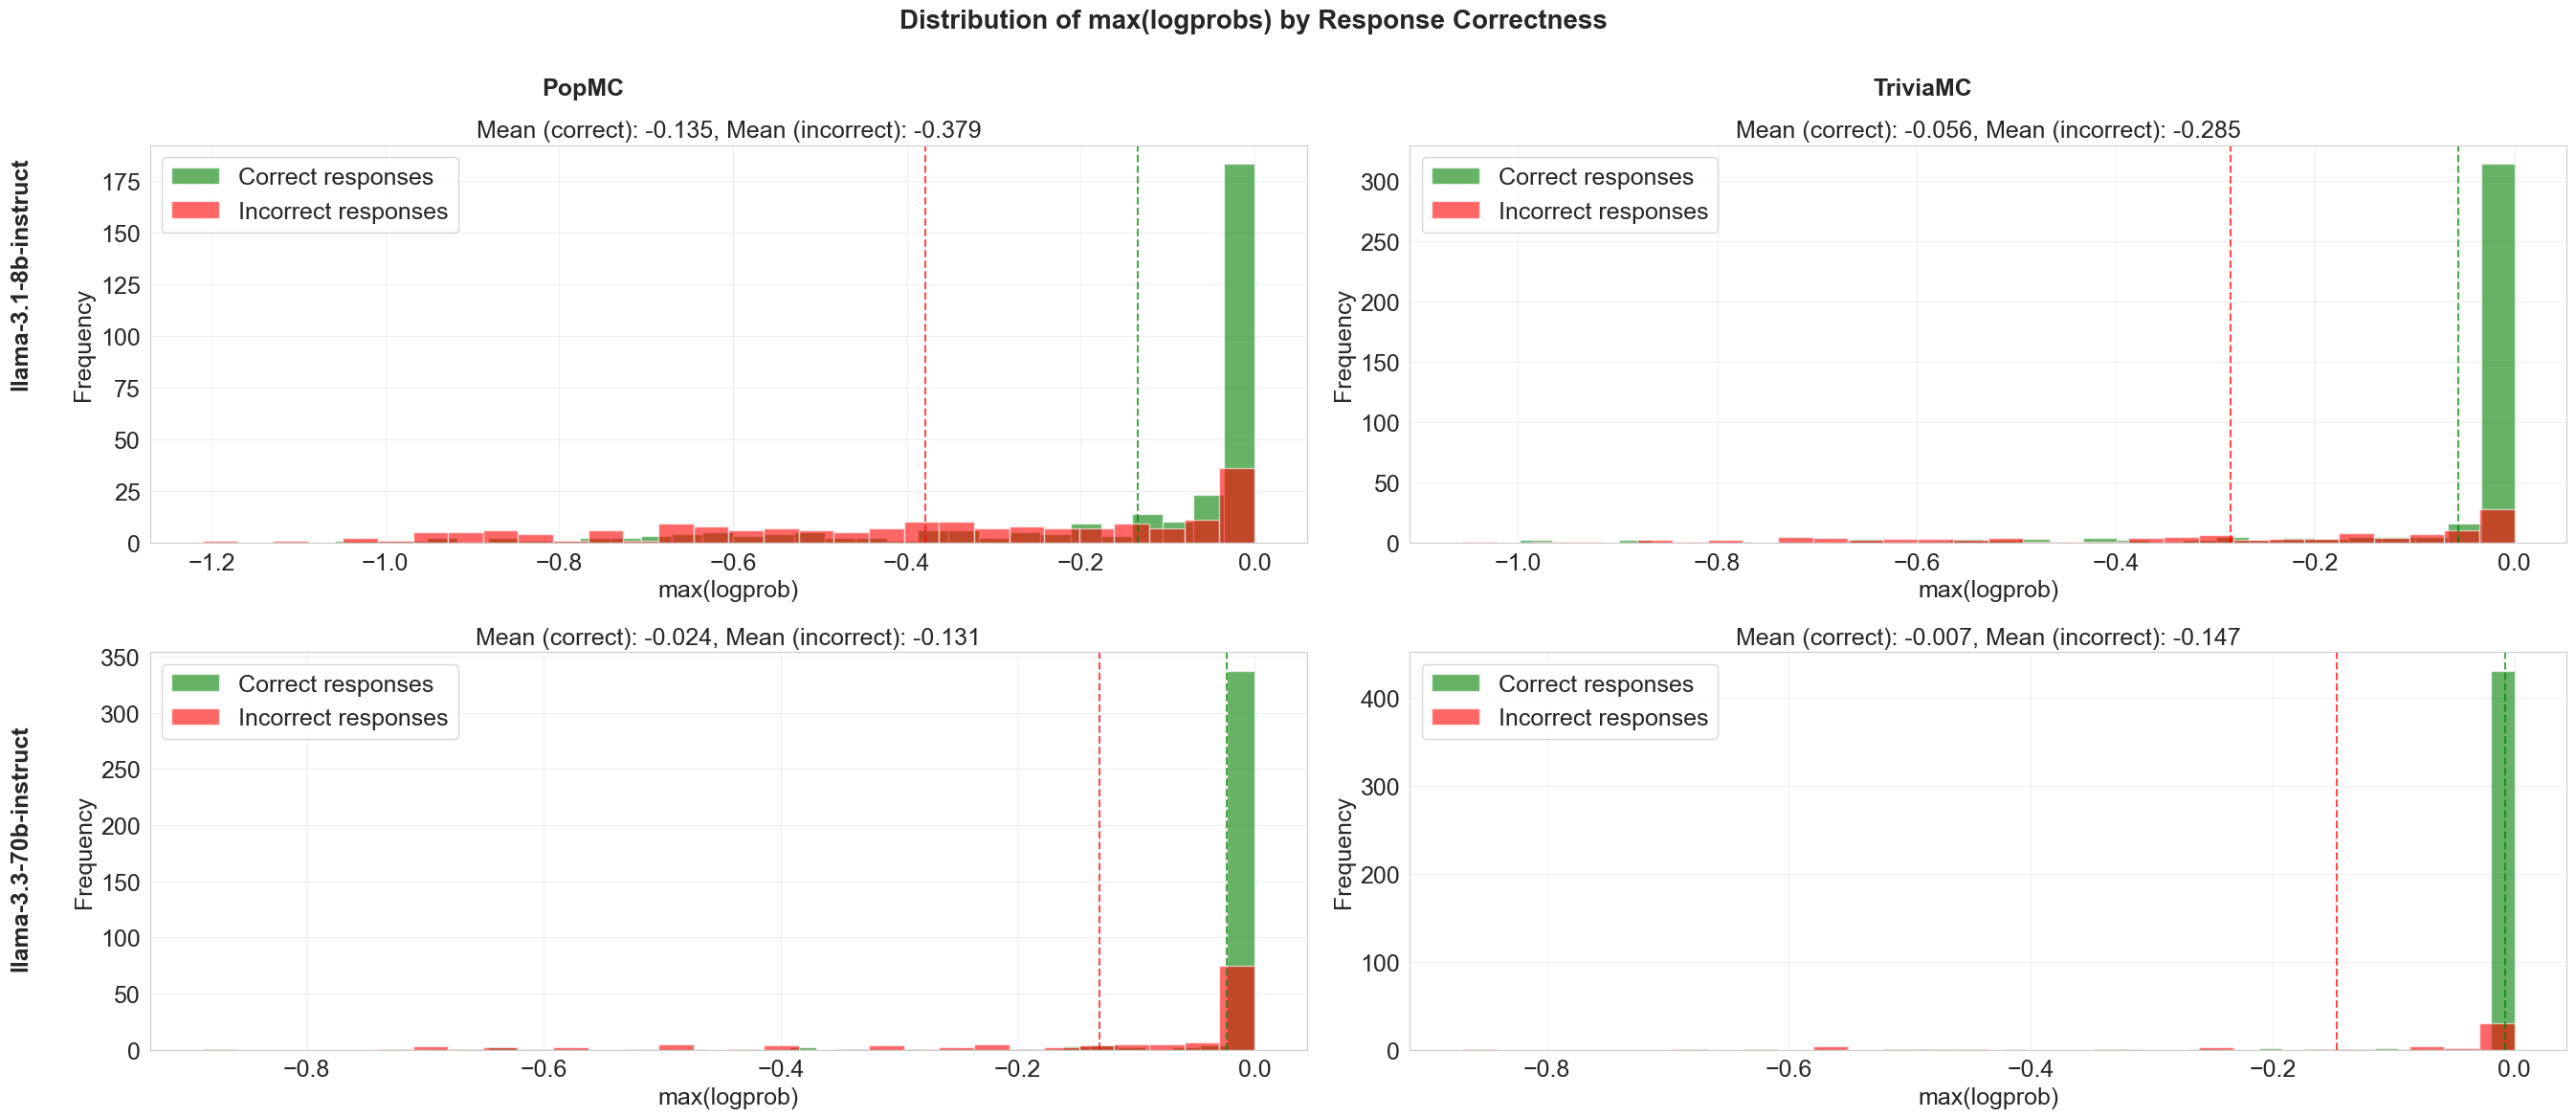

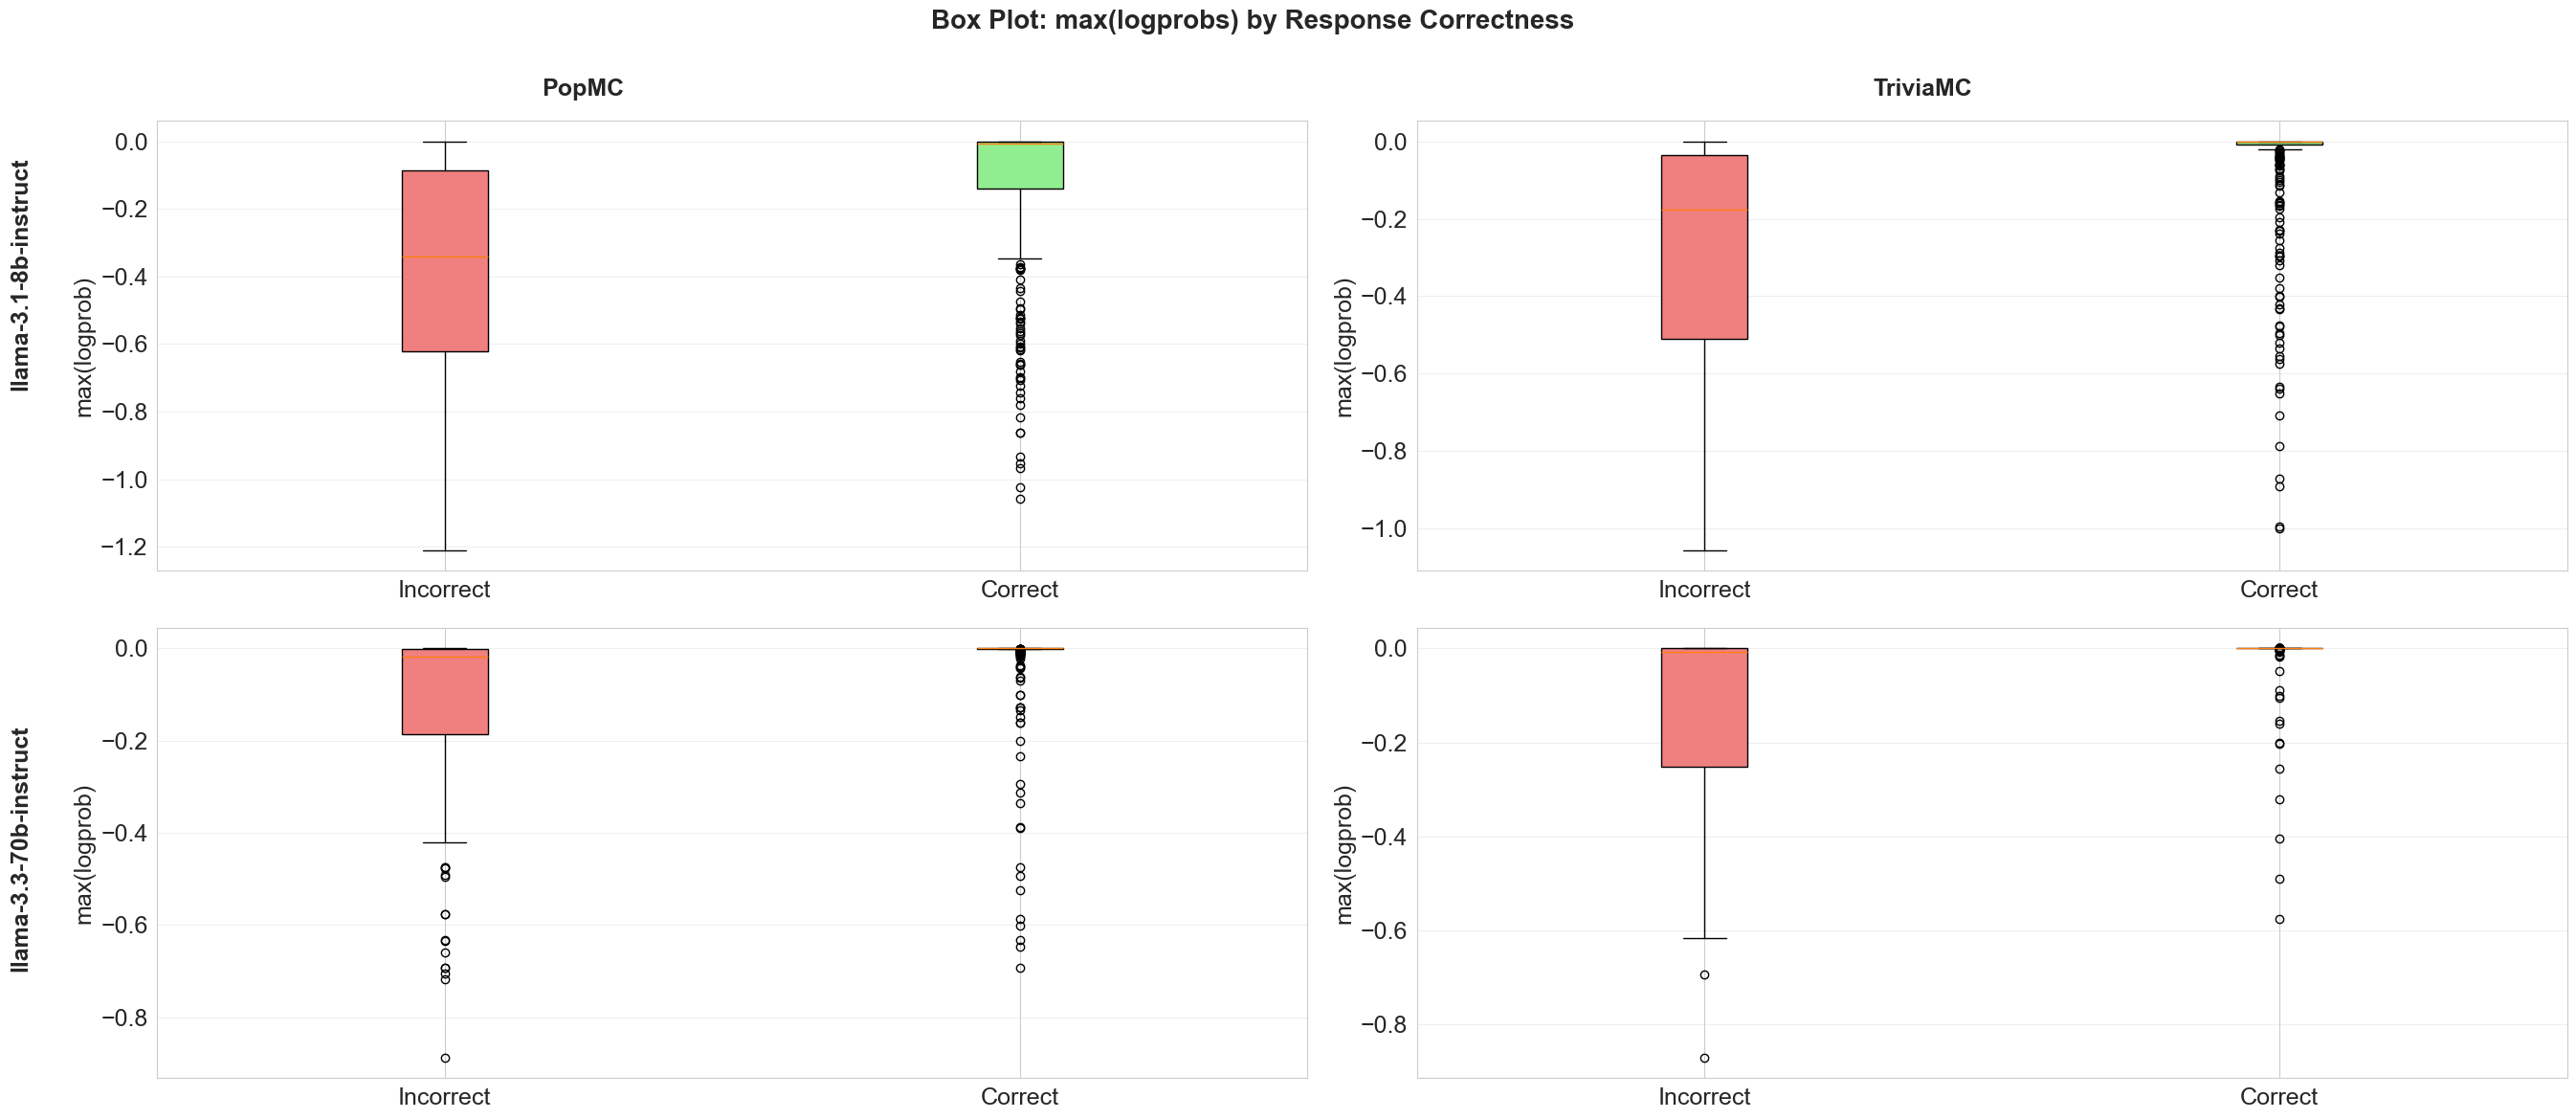

STATISTICS: max(logprobs) Distribution

Summary Statistics Table:
                 Model     Test    Mean  Median Std Dev Variance     Min     Max Q1 (25%) Q3 (75%)    IQR Mean (correct) Mean (incorrect) Std (correct) Std (incorrect) Var (correct) Var (incorrect)   N
 llama-3.1-8b-instruct    PopMC -0.2291 -0.0694  0.2901   0.0842 -1.2102 -0.0000  -0.3993  -0.0013 0.3980        -0.1347          -0.3793        0.2344          0.3070        0.0549          0.0942 500
 llama-3.1-8b-instruct TriviaMC -0.1085 -0.0005  0.2161   0.0467 -1.0560 -0.0000  -0.0866  -0.0000 0.0866        -0.0563          -0.2849        0.1576          0.2843        0.0248          0.0808 500
llama-3.3-70b-instruct    PopMC -0.0518 -0.0000  0.1423   0.0203 -0.8880  0.0000  -0.0086   0.0000 0.0086        -0.0236          -0.1307        0.0966          0.2062        0.0093          0.0425 500
llama-3.3-70b-instruct TriviaMC -0.0219  0.0000  0.0983   0.0097 -0.8702  0.0000  -0.0000   0.0000 0.0000        -0.0072      

In [ ]:
# Distribution of max(logprobs) - side by side for each model/test combination
n_combos = len(all_dfs)
if n_combos > 0:
    # Organize data into model x test grid
    grid_data, available_models, available_tests = create_model_test_grid(all_dfs, MODELS, TESTS)
    n_rows = len(available_models)
    n_cols = len(available_tests)
    
    # Plot 1: Histogram of max_logprob distribution
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(14 * n_cols, 6 * n_rows))
    if n_rows == 1:
        axes = axes.reshape(1, -1) if n_cols > 1 else axes.reshape(1, 1)
    elif n_cols == 1:
        axes = axes.reshape(-1, 1)
    
    fig.suptitle('Distribution of max(logprobs)', fontsize=FONT_SIZE + 2, fontweight='bold')
    
    for row_idx, model in enumerate(available_models):
        for col_idx, test in enumerate(available_tests):
            ax = axes[row_idx, col_idx]
            if model in grid_data and test in grid_data[model]:
                df = grid_data[model][test]
                max_logprobs = df['max_logprob']
                
                # Create histogram
                ax.hist(max_logprobs, bins=50, alpha=0.7, color='steelblue', edgecolor='black')
                
                # Add vertical lines for mean and median
                mean_val = max_logprobs.mean()
                median_val = max_logprobs.median()
                ax.axvline(mean_val, color='red', linestyle='--', linewidth=2, label=f'Mean: {mean_val:.3f}')
                ax.axvline(median_val, color='green', linestyle='--', linewidth=2, label=f'Median: {median_val:.3f}')
                
                ax.set_xlabel('max(logprob)')
                ax.set_ylabel('Frequency')
                ax.set_title('')
                ax.legend()
                ax.grid(True, alpha=0.3)
            else:
                ax.set_visible(False)
    
    # Add model and test labels
    add_model_test_labels(fig, axes, available_models, available_tests, n_rows, n_cols)
    
    plt.tight_layout(rect=[0.05, 0, 1, 0.95])
    plt.show()
    
    # Plot 2: Distribution of max_logprob by response correctness
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(14 * n_cols, 6 * n_rows))
    if n_rows == 1:
        axes = axes.reshape(1, -1) if n_cols > 1 else axes.reshape(1, 1)
    elif n_cols == 1:
        axes = axes.reshape(-1, 1)
    
    fig.suptitle('Distribution of max(logprobs) by Response Correctness', fontsize=FONT_SIZE + 2, fontweight='bold')
    
    for row_idx, model in enumerate(available_models):
        for col_idx, test in enumerate(available_tests):
            ax = axes[row_idx, col_idx]
            if model in grid_data and test in grid_data[model]:
                df = grid_data[model][test]
                correct_logprobs = df[df['is_correct']]['max_logprob']
                incorrect_logprobs = df[~df['is_correct']]['max_logprob']
                
                ax.hist(correct_logprobs, bins=30, alpha=0.6, label='Correct responses', color='green')
                ax.hist(incorrect_logprobs, bins=30, alpha=0.6, label='Incorrect responses', color='red')
                ax.set_xlabel('max(logprob)')
                ax.set_ylabel('Frequency')
                ax.set_title(f'Mean (correct): {correct_logprobs.mean():.3f}, Mean (incorrect): {incorrect_logprobs.mean():.3f}')
                ax.legend()
                ax.axvline(correct_logprobs.mean(), color='green', linestyle='--', alpha=0.7)
                ax.axvline(incorrect_logprobs.mean(), color='red', linestyle='--', alpha=0.7)
                ax.grid(True, alpha=0.3)
            else:
                ax.set_visible(False)
    
    # Add model and test labels
    add_model_test_labels(fig, axes, available_models, available_tests, n_rows, n_cols)
    
    plt.tight_layout(rect=[0.05, 0, 1, 0.95])
    plt.show()
    
    # Plot 3: Box plot of max_logprob by response correctness
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(14 * n_cols, 6 * n_rows))
    if n_rows == 1:
        axes = axes.reshape(1, -1) if n_cols > 1 else axes.reshape(1, 1)
    elif n_cols == 1:
        axes = axes.reshape(-1, 1)
    
    fig.suptitle('Box Plot: max(logprobs) by Response Correctness', fontsize=FONT_SIZE + 2, fontweight='bold')
    
    for row_idx, model in enumerate(available_models):
        for col_idx, test in enumerate(available_tests):
            ax = axes[row_idx, col_idx]
            if model in grid_data and test in grid_data[model]:
                df = grid_data[model][test]
                correct_logprobs = df[df['is_correct']]['max_logprob']
                incorrect_logprobs = df[~df['is_correct']]['max_logprob']
                
                bp = ax.boxplot([incorrect_logprobs, correct_logprobs], 
                                tick_labels=['Incorrect', 'Correct'],
                                patch_artist=True)
                bp['boxes'][0].set_facecolor('lightcoral')
                bp['boxes'][1].set_facecolor('lightgreen')
                
                ax.set_ylabel('max(logprob)')
                ax.set_title('')
                ax.grid(True, alpha=0.3, axis='y')
            else:
                ax.set_visible(False)
    
    # Add model and test labels
    add_model_test_labels(fig, axes, available_models, available_tests, n_rows, n_cols)
    
    plt.tight_layout(rect=[0.05, 0, 1, 0.95])
    plt.show()
    
    # Print statistics table
    print("=" * 80)
    print("STATISTICS: max(logprobs) Distribution")
    print("=" * 80)
    
    stats_list = []
    for key, df in all_dfs.items():
        model, test = key.split('_', 1) if '_' in key else (key, '')
        max_logprobs = df['max_logprob']
        correct_logprobs = df[df['is_correct']]['max_logprob']
        incorrect_logprobs = df[~df['is_correct']]['max_logprob']
        
        stats = {
            'Model': model,
            'Test': test,
            'Mean': f"{max_logprobs.mean():.4f}",
            'Median': f"{max_logprobs.median():.4f}",
            'Std Dev': f"{max_logprobs.std():.4f}",
            'Variance': f"{max_logprobs.var():.4f}",
            'Min': f"{max_logprobs.min():.4f}",
            'Max': f"{max_logprobs.max():.4f}",
            'Q1 (25%)': f"{max_logprobs.quantile(0.25):.4f}",
            'Q3 (75%)': f"{max_logprobs.quantile(0.75):.4f}",
            'IQR': f"{max_logprobs.quantile(0.75) - max_logprobs.quantile(0.25):.4f}",
            'Mean (correct)': f"{correct_logprobs.mean():.4f}",
            'Mean (incorrect)': f"{incorrect_logprobs.mean():.4f}",
            'Std (correct)': f"{correct_logprobs.std():.4f}",
            'Std (incorrect)': f"{incorrect_logprobs.std():.4f}",
            'Var (correct)': f"{correct_logprobs.var():.4f}",
            'Var (incorrect)': f"{incorrect_logprobs.var():.4f}",
            'N': len(df)
        }
        stats_list.append(stats)
    
    stats_df = pd.DataFrame(stats_list)
    print("\nSummary Statistics Table:")
    print(stats_df.to_string(index=False))
    print()
    
    # Detailed statistics by model/test
    print("=" * 80)
    print("DETAILED STATISTICS BY MODEL/TEST")
    print("=" * 80)
    for key, df in all_dfs.items():
        model, test = key.split('_', 1) if '_' in key else (key, '')
        max_logprobs = df['max_logprob']
        correct_logprobs = df[df['is_correct']]['max_logprob']
        incorrect_logprobs = df[~df['is_correct']]['max_logprob']
        
        print(f"\n--- {model} - {test} ---")
        print(f"Overall Statistics:")
        print(f"  Mean: {max_logprobs.mean():.4f}")
        print(f"  Median: {max_logprobs.median():.4f}")
        print(f"  Standard Deviation: {max_logprobs.std():.4f}")
        print(f"  Variance: {max_logprobs.var():.4f}")
        print(f"  Min: {max_logprobs.min():.4f}")
        print(f"  Max: {max_logprobs.max():.4f}")
        print(f"  Q1 (25th percentile): {max_logprobs.quantile(0.25):.4f}")
        print(f"  Q3 (75th percentile): {max_logprobs.quantile(0.75):.4f}")
        print(f"  IQR: {max_logprobs.quantile(0.75) - max_logprobs.quantile(0.25):.4f}")
        print(f"\nBy Correctness:")
        print(f"  Correct responses:")
        print(f"    Mean: {correct_logprobs.mean():.4f}")
        print(f"    Std Dev: {correct_logprobs.std():.4f}")
        print(f"    Variance: {correct_logprobs.var():.4f}")
        print(f"  Incorrect responses:")
        print(f"    Mean: {incorrect_logprobs.mean():.4f}")
        print(f"    Std Dev: {incorrect_logprobs.std():.4f}")
        print(f"    Variance: {incorrect_logprobs.var():.4f}")
else:
    print("No data to plot!")


In [6]:
# Entropy Analysis: Entropy vs Correctness, Entropy vs max_prob, and -entropy as confidence predictor
n_combos = len(all_dfs)
if n_combos > 0:
    # ============================================================================
    # 1. Entropy vs Correctness: Distribution of H for correct vs incorrect
    # ============================================================================
    # Organize data into model x test grid
    grid_data, available_models, available_tests = create_model_test_grid(all_dfs, MODELS, TESTS)
    n_rows = len(available_models)
    n_cols = len(available_tests)
    
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(14 * n_cols, 6 * n_rows))
    if n_rows == 1:
        axes = axes.reshape(1, -1) if n_cols > 1 else axes.reshape(1, 1)
    elif n_cols == 1:
        axes = axes.reshape(-1, 1)
    
    fig.suptitle('Distribution of Entropy (H) by Response Correctness', fontsize=FONT_SIZE + 2, fontweight='bold')
    
    for row_idx, model in enumerate(available_models):
        for col_idx, test in enumerate(available_tests):
            ax = axes[row_idx, col_idx]
            if model in grid_data and test in grid_data[model]:
                df = grid_data[model][test]
                correct_entropy = df[df['is_correct']]['entropy']
                incorrect_entropy = df[~df['is_correct']]['entropy']
                
                ax.hist(correct_entropy, bins=30, alpha=0.6, label='Correct responses', color='green')
                ax.hist(incorrect_entropy, bins=30, alpha=0.6, label='Incorrect responses', color='red')
                ax.set_xlabel('Entropy (H)')
                ax.set_ylabel('Frequency')
                
                mean_correct = correct_entropy.mean()
                mean_incorrect = incorrect_entropy.mean()
                ax.set_title(f'Mean H (correct): {mean_correct:.3f}, Mean H (incorrect): {mean_incorrect:.3f}')
                ax.legend()
                ax.axvline(mean_correct, color='green', linestyle='--', alpha=0.7)
                ax.axvline(mean_incorrect, color='red', linestyle='--', alpha=0.7)
                ax.grid(True, alpha=0.3)
            else:
                ax.set_visible(False)
    
    # Add model and test labels
    add_model_test_labels(fig, axes, available_models, available_tests, n_rows, n_cols)
    
    plt.tight_layout(rect=[0.05, 0, 1, 0.95])
    plt.show()
    
    # ============================================================================
    # 2. Entropy vs max_prob: Scatter plot colored by correctness
    # ============================================================================
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(14 * n_cols, 8 * n_rows))
    if n_rows == 1:
        axes = axes.reshape(1, -1) if n_cols > 1 else axes.reshape(1, 1)
    elif n_cols == 1:
        axes = axes.reshape(-1, 1)
    
    fig.suptitle('Entropy (H) vs max_prob, Colored by Correctness', fontsize=FONT_SIZE + 2, fontweight='bold')
    
    for row_idx, model in enumerate(available_models):
        for col_idx, test in enumerate(available_tests):
            ax = axes[row_idx, col_idx]
            if model in grid_data and test in grid_data[model]:
                df = grid_data[model][test]
                correct_mask = df['is_correct']
                ax.scatter(df[correct_mask]['max_prob'], df[correct_mask]['entropy'], 
                           alpha=0.5, label='Correct responses', color='green', s=30)
                ax.scatter(df[~correct_mask]['max_prob'], df[~correct_mask]['entropy'], 
                           alpha=0.5, label='Incorrect responses', color='red', s=30)
                
                # Highlight dangerous overconfidence region: low entropy, high max_prob but wrong
                dangerous = df[(~df['is_correct']) & (df['entropy'] < df['entropy'].quantile(0.25)) & 
                               (df['max_prob'] > df['max_prob'].quantile(0.75))]
                if len(dangerous) > 0:
                    ax.scatter(dangerous['max_prob'], dangerous['entropy'], 
                              alpha=0.8, s=100, marker='x', color='darkred', 
                              label=f'Dangerous overconfidence (n={len(dangerous)})', linewidths=2)
                
                ax.set_xlabel('max_prob (Confidence)')
                ax.set_ylabel('Entropy (H)')
                ax.set_title('')
                ax.legend()
                ax.grid(True, alpha=0.3)
            else:
                ax.set_visible(False)
    
    # Add model and test labels
    add_model_test_labels(fig, axes, available_models, available_tests, n_rows, n_cols)
    
    plt.tight_layout(rect=[0.05, 0, 1, 0.95])
    plt.show()
    
    # ============================================================================
    # 3. Correlation / AUC using -entropy as a predictor
    # ============================================================================
    print("=" * 80)
    print("CORRELATION AND AUC: -entropy as Confidence Predictor")
    print("=" * 80)
    
    # Compute -entropy for all dataframes
    for key, df in all_dfs.items():
        df['neg_entropy'] = -df['entropy']
    
    correlation_results = []
    for key, df in all_dfs.items():
        model, test = key.split('_', 1) if '_' in key else (key, '')
        
        # Point-biserial correlation: -entropy vs is_correct
        r_neg_entropy, p_neg_entropy = pointbiserialr(df['neg_entropy'], df['is_correct'])
        
        # Point-biserial correlation: max_prob vs is_correct (for comparison)
        r_max_prob, p_max_prob = pointbiserialr(df['max_prob'], df['is_correct'])
        
        # ROC AUC: -entropy vs is_correct
        try:
            auc_neg_entropy = roc_auc_score(df['is_correct'], df['neg_entropy'])
        except ValueError:
            auc_neg_entropy = np.nan
        
        # ROC AUC: max_prob vs is_correct (for comparison)
        try:
            auc_max_prob = roc_auc_score(df['is_correct'], df['max_prob'])
        except ValueError:
            auc_max_prob = np.nan
        
        correlation_results.append({
            'Model': model,
            'Test': test,
            'r(-entropy)': f"{r_neg_entropy:.4f}",
            'p(-entropy)': f"{p_neg_entropy:.4e}",
            'AUC(-entropy)': f"{auc_neg_entropy:.4f}",
            'r(max_prob)': f"{r_max_prob:.4f}",
            'p(max_prob)': f"{p_max_prob:.4e}",
            'AUC(max_prob)': f"{auc_max_prob:.4f}",
            'AUC diff': f"{auc_neg_entropy - auc_max_prob:.4f}",
            'N': len(df)
        })
        
        print(f"\n{model} - {test}:")
        print(f"  Point-biserial correlation:")
        print(f"    -entropy vs correctness: r = {r_neg_entropy:.4f}, p = {p_neg_entropy:.4e}")
        print(f"    max_prob vs correctness: r = {r_max_prob:.4f}, p = {p_max_prob:.4e}")
        print(f"  ROC AUC:")
        print(f"    -entropy: {auc_neg_entropy:.4f}")
        print(f"    max_prob: {auc_max_prob:.4f}")
        print(f"    Difference (entropy - max_prob): {auc_neg_entropy - auc_max_prob:.4f}")
        if auc_neg_entropy > auc_max_prob:
            print(f"    → -entropy performs BETTER than max_prob")
        elif auc_neg_entropy < auc_max_prob:
            print(f"    → max_prob performs BETTER than -entropy")
        else:
            print(f"    → -entropy and max_prob perform similarly")
    
    corr_df = pd.DataFrame(correlation_results)
    print("\n" + "=" * 80)
    print("Summary Table:")
    print("=" * 80)
    print(corr_df.to_string(index=False))
    
    # Visualization: Side-by-side comparison of -entropy vs max_prob as predictors
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(16 * n_cols, 6 * n_rows))
    if n_rows == 1:
        axes = axes.reshape(1, -1) if n_cols > 1 else axes.reshape(1, 1)
    elif n_cols == 1:
        axes = axes.reshape(-1, 1)
    
    fig.suptitle('Comparison: -entropy vs max_prob as Confidence Predictors', 
                 fontsize=FONT_SIZE + 2, fontweight='bold')
    
    for row_idx, model in enumerate(available_models):
        for col_idx, test in enumerate(available_tests):
            ax = axes[row_idx, col_idx]
            if model in grid_data and test in grid_data[model]:
                df = grid_data[model][test]
                # Compute correlations and AUCs
                r_neg_entropy, _ = pointbiserialr(df['neg_entropy'], df['is_correct'])
                r_max_prob, _ = pointbiserialr(df['max_prob'], df['is_correct'])
                auc_neg_entropy = roc_auc_score(df['is_correct'], df['neg_entropy'])
                auc_max_prob = roc_auc_score(df['is_correct'], df['max_prob'])
                
                # Create scatter plot with logistic regression fits
                # Normalize both to [0, 1] for comparison
                neg_entropy_norm = (df['neg_entropy'] - df['neg_entropy'].min()) / (df['neg_entropy'].max() - df['neg_entropy'].min())
                max_prob_norm = df['max_prob']  # Already in [0, 1]
                
                # Scatter plots
                ax.scatter(neg_entropy_norm, df['is_correct'] + np.random.normal(0, 0.02, len(df)), 
                          alpha=0.3, label=f'-entropy (r={r_neg_entropy:.3f}, AUC={auc_neg_entropy:.3f})', 
                          color='blue', s=20)
                ax.scatter(max_prob_norm, df['is_correct'] + np.random.normal(0, 0.02, len(df)), 
                          alpha=0.3, label=f'max_prob (r={r_max_prob:.3f}, AUC={auc_max_prob:.3f})', 
                          color='orange', s=20)
                
                # Logistic regression fits
                X_neg = df['neg_entropy'].values.reshape(-1, 1)
                X_max = df['max_prob'].values.reshape(-1, 1)
                y = df['is_correct'].values
                
                clf_neg = LogisticRegression().fit(X_neg, y)
                clf_max = LogisticRegression().fit(X_max, y)
                
                xx_neg = np.linspace(df['neg_entropy'].min(), df['neg_entropy'].max(), 200)
                yy_neg = clf_neg.predict_proba(xx_neg.reshape(-1, 1))[:, 1]
                xx_neg_norm = (xx_neg - df['neg_entropy'].min()) / (df['neg_entropy'].max() - df['neg_entropy'].min())
                
                xx_max = np.linspace(0, 1, 200)
                yy_max = clf_max.predict_proba(xx_max.reshape(-1, 1))[:, 1]
                
                ax.plot(xx_neg_norm, yy_neg, color='blue', linewidth=2, linestyle='--')
                ax.plot(xx_max, yy_max, color='orange', linewidth=2, linestyle='--')
                
                ax.set_xlabel('Normalized Confidence Score')
                ax.set_ylabel('Correctness (0/1)')
                ax.set_title('')
                ax.set_ylim(-0.1, 1.1)
                ax.legend()
                ax.grid(True, alpha=0.3)
            else:
                ax.set_visible(False)
    
    # Add model and test labels
    add_model_test_labels(fig, axes, available_models, available_tests, n_rows, n_cols)
    
    plt.tight_layout(rect=[0.05, 0, 1, 0.95])
    plt.show()
    
    # Summary statistics for entropy analysis
    print("\n" + "=" * 80)
    print("ENTROPY SUMMARY STATISTICS")
    print("=" * 80)
    
    entropy_stats_list = []
    for key, df in all_dfs.items():
        model, test = key.split('_', 1) if '_' in key else (key, '')
        correct_entropy = df[df['is_correct']]['entropy']
        incorrect_entropy = df[~df['is_correct']]['entropy']
        
        mean_correct = correct_entropy.mean()
        mean_incorrect = incorrect_entropy.mean()
        ratio = mean_incorrect / mean_correct if mean_correct > 0 else np.inf
        
        entropy_stats_list.append({
            'Model': model,
            'Test': test,
            'Mean H (correct)': f"{mean_correct:.4f}",
            'Mean H (incorrect)': f"{mean_incorrect:.4f}",
            'Ratio (incorrect/correct)': f"{ratio:.2f}",
            'N': len(df)
        })
    
    entropy_stats_df = pd.DataFrame(entropy_stats_list)
    print("\nSummary Statistics Table:")
    print(entropy_stats_df.to_string(index=False))
    # print("\nNote: 'Knows when unsure?' is Yes if mean(H_incorrect) > 1.2 * mean(H_correct)")
    
else:
    print("No data to analyze!")


NameError: name 'create_model_test_grid' is not defined

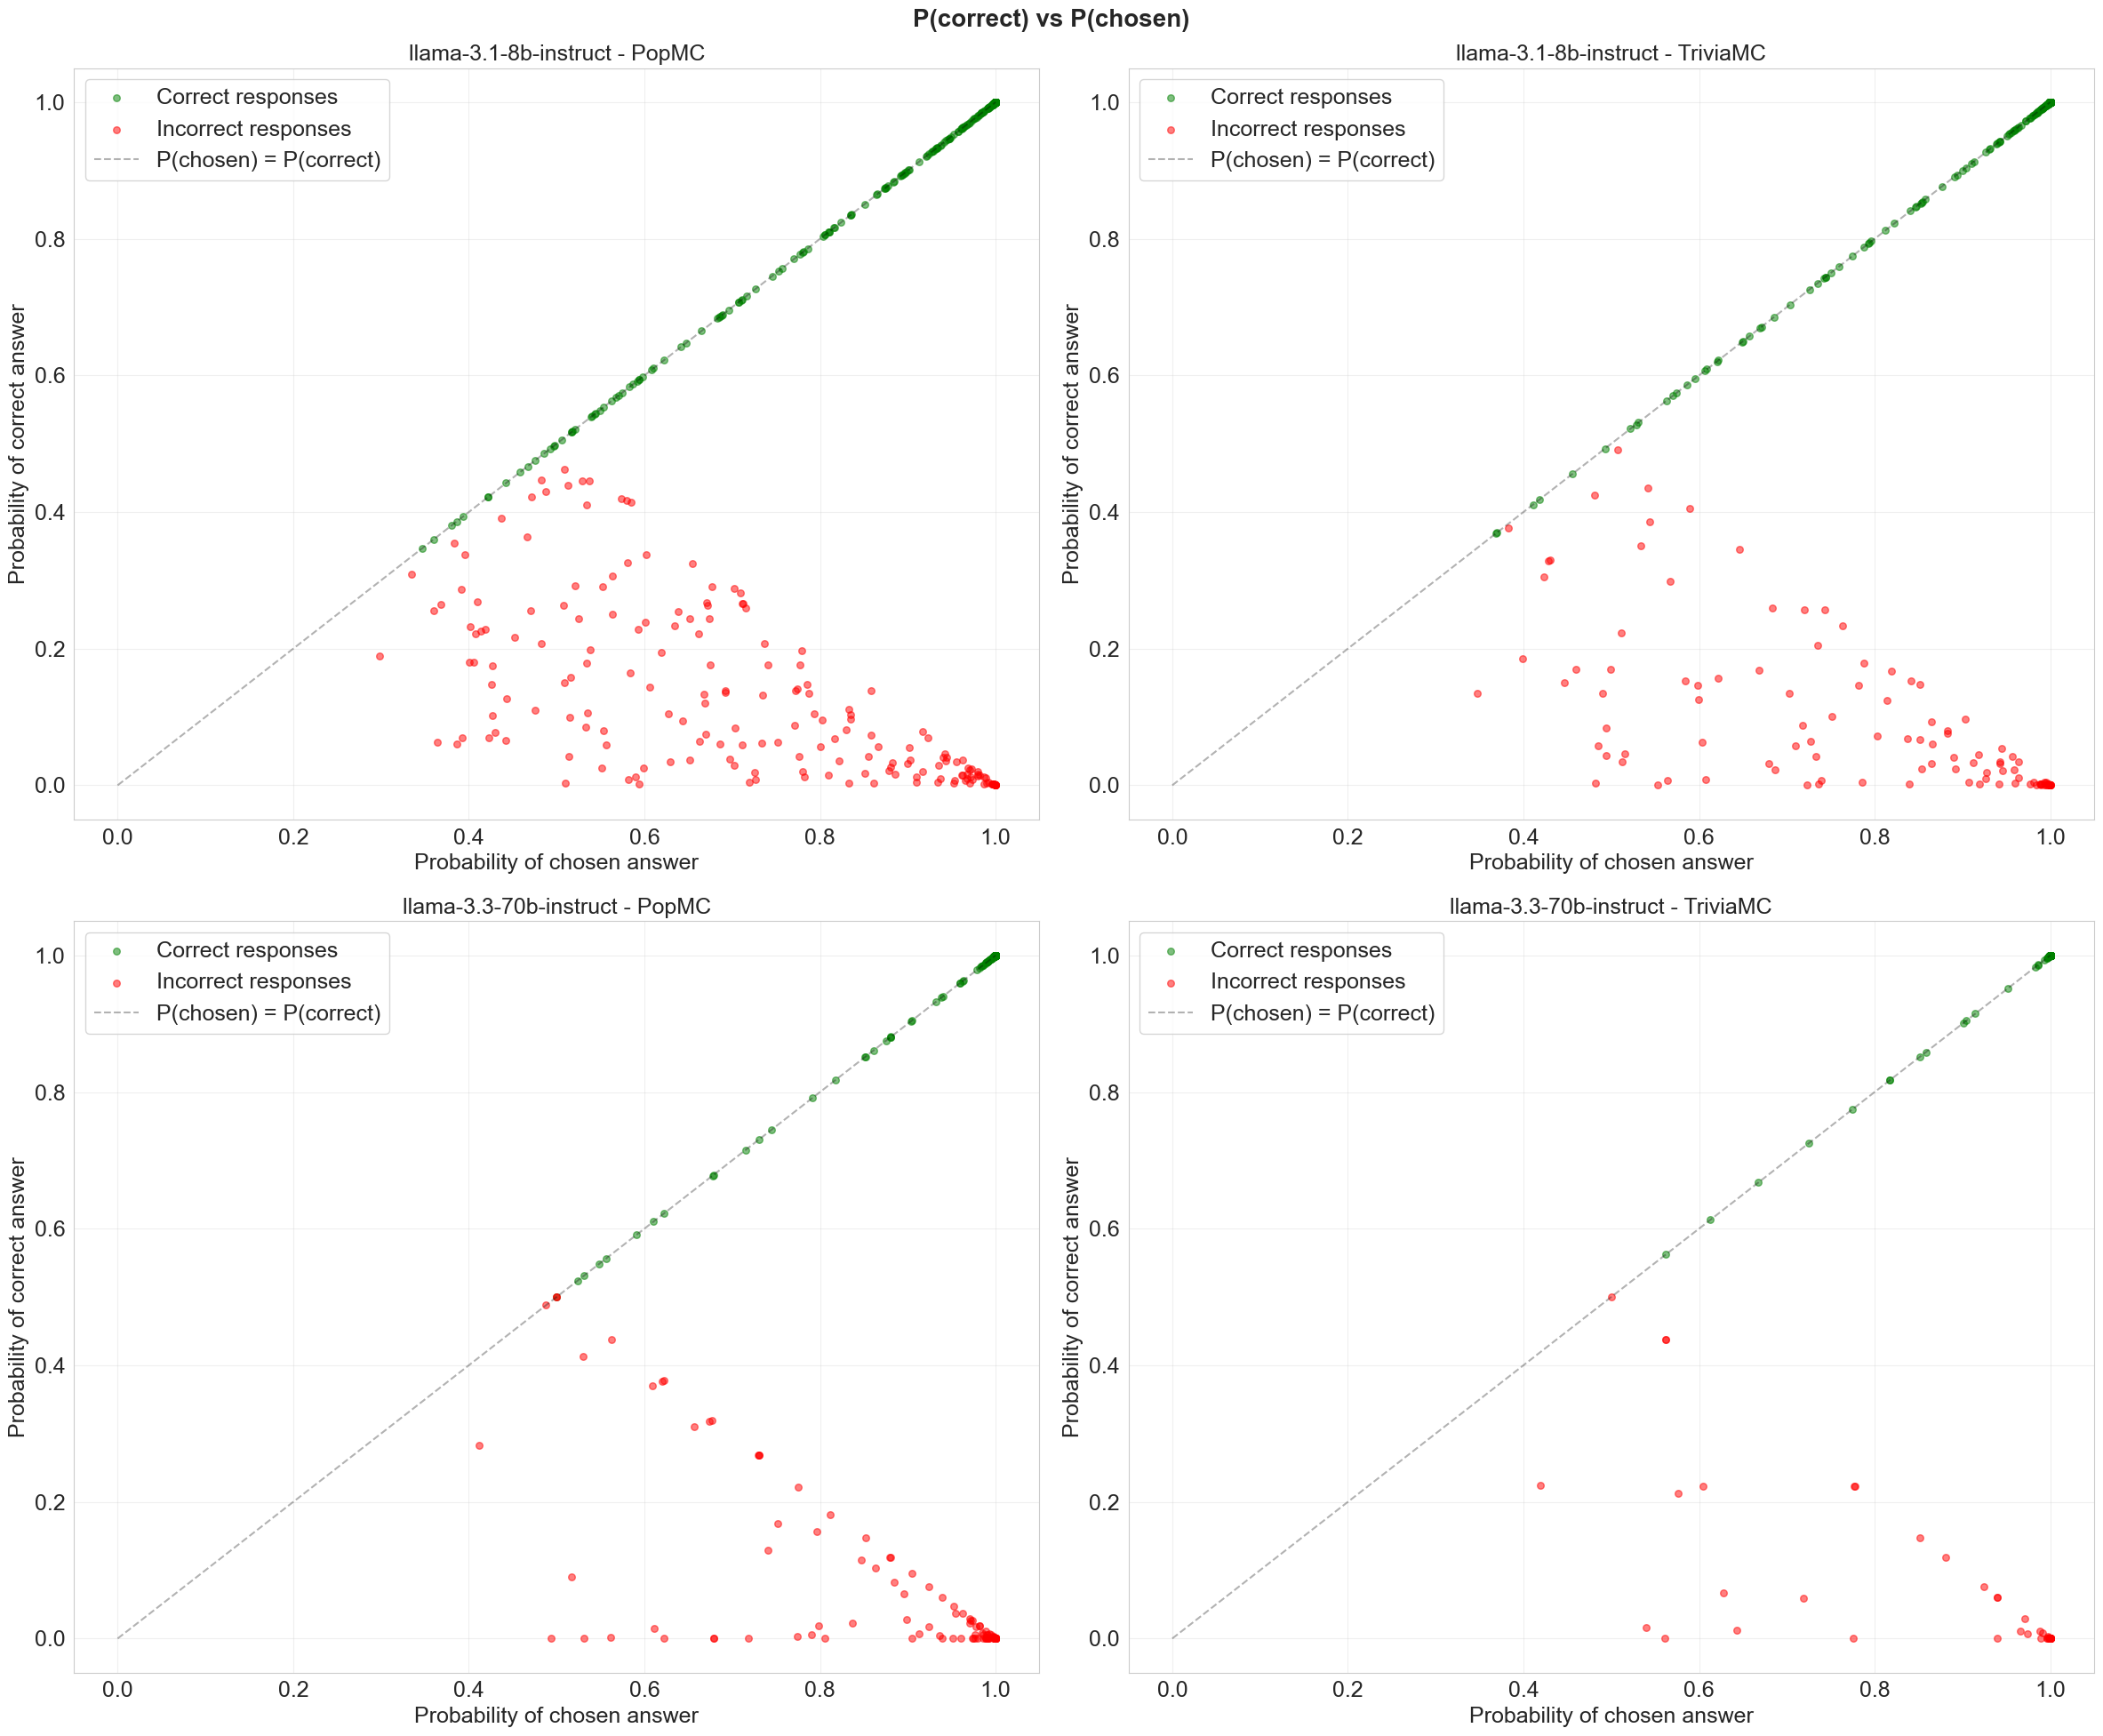

In [ ]:
# Scatter plots: P(correct) vs P(chosen) - side by side
n_combos = len(all_dfs)
if n_combos > 0:
    n_cols = min(2, n_combos)
    n_rows = math.ceil(n_combos / n_cols)
    
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(12 * n_cols, 10 * n_rows))
    if n_combos == 1:
        axes = [axes]
    elif n_rows == 1:
        axes = axes if isinstance(axes, np.ndarray) else [axes]
    else:
        axes = axes.flatten()
    
    fig.suptitle('P(correct) vs P(chosen)', fontsize=FONT_SIZE + 2, fontweight='bold')
    
    for idx, (key, df) in enumerate(all_dfs.items()):
        ax = axes[idx] if n_combos > 1 else axes[0]
        model, test = key.split('_', 1) if '_' in key else (key, '')
        
        correct_mask = df['is_correct']
        ax.scatter(df[correct_mask]['prob_chosen'], df[correct_mask]['prob_correct'], 
                   alpha=0.5, label='Correct responses', color='green', s=30)
        ax.scatter(df[~correct_mask]['prob_chosen'], df[~correct_mask]['prob_correct'], 
                   alpha=0.5, label='Incorrect responses', color='red', s=30)
        
        # Diagonal line (where chosen = correct)
        ax.plot([0, 1], [0, 1], 'k--', alpha=0.3, label='P(chosen) = P(correct)')
        
        ax.set_xlabel('Probability of chosen answer')
        ax.set_ylabel('Probability of correct answer')
        ax.set_title(f'{model} - {test}')
        ax.legend()
        ax.grid(True, alpha=0.3)
    
    for idx in range(n_combos, len(axes)):
        axes[idx].set_visible(False)
    
    plt.tight_layout()
    plt.show()


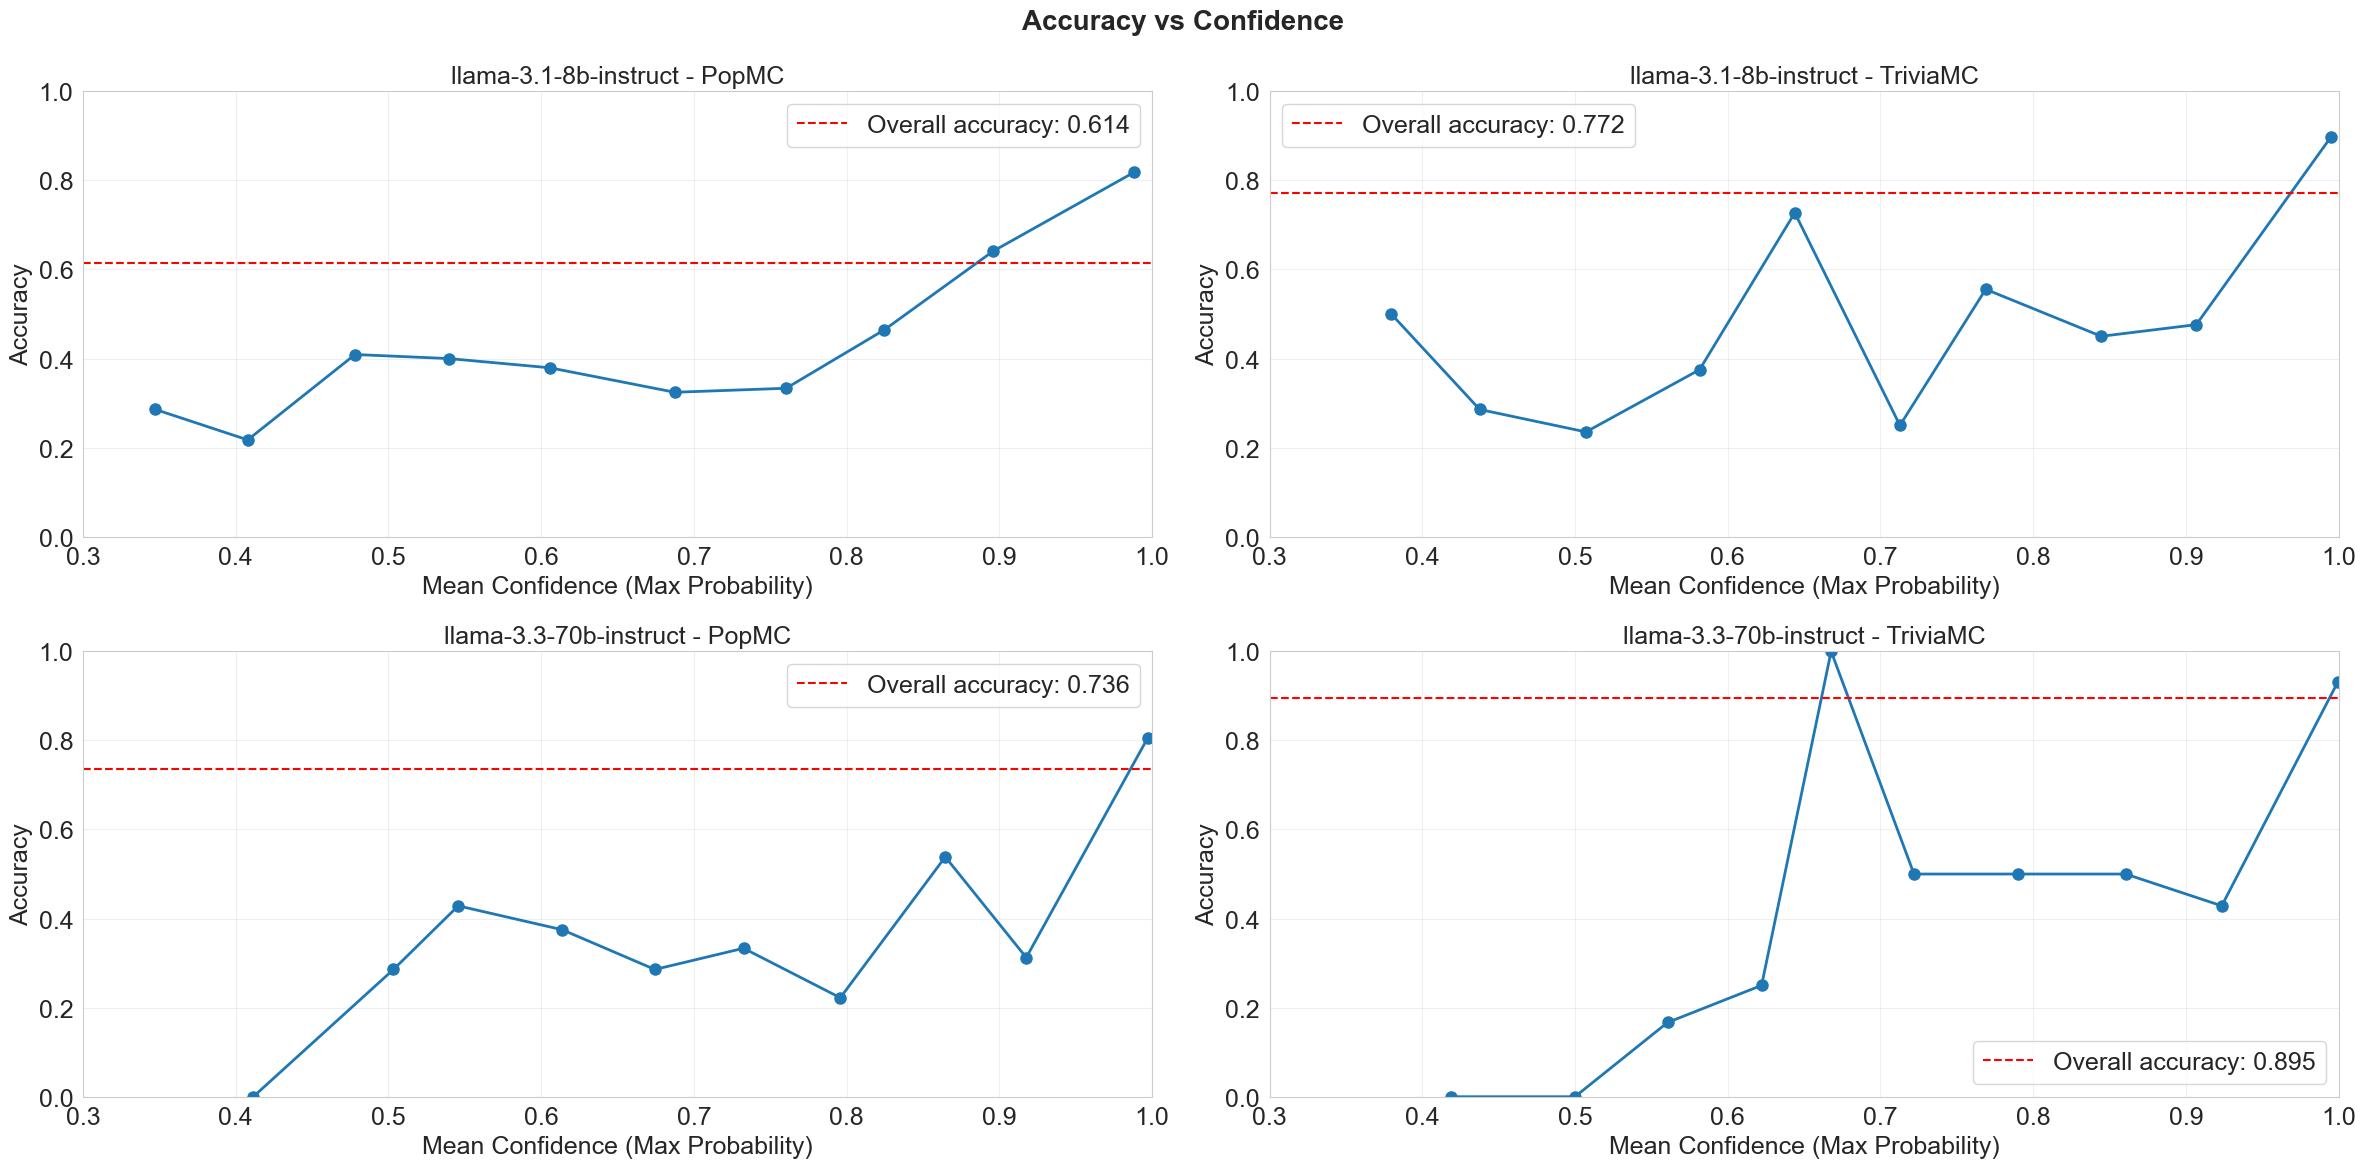

In [ ]:
# Confidence vs Accuracy analysis - side by side
n_combos = len(all_dfs)
if n_combos > 0:
    n_cols = min(2, n_combos)
    n_rows = math.ceil(n_combos / n_cols)
    
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(12 * n_cols, 6 * n_rows))
    if n_combos == 1:
        axes = [axes]
    elif n_rows == 1:
        axes = axes if isinstance(axes, np.ndarray) else [axes]
    else:
        axes = axes.flatten()
    
    fig.suptitle('Accuracy vs Confidence', fontsize=FONT_SIZE + 2, fontweight='bold')
    
    for idx, (key, df) in enumerate(all_dfs.items()):
        ax = axes[idx] if n_combos > 1 else axes[0]
        model, test = key.split('_', 1) if '_' in key else (key, '')
        
        df['confidence_bin'] = pd.cut(df['max_prob'], bins=10, labels=False)
        confidence_accuracy = df.groupby('confidence_bin').agg({
            'is_correct': 'mean',
            'max_prob': 'mean'
        }).reset_index()
        
        ax.plot(confidence_accuracy['max_prob'], confidence_accuracy['is_correct'], 
                marker='o', linewidth=2, markersize=8)
        ax.set_xlabel('Mean Confidence (Max Probability)')
        ax.set_ylabel('Accuracy')
        ax.set_xlim(0.3, 1)
        ax.set_ylim(0, 1)
        ax.set_title(f'{model} - {test}')
        ax.grid(True, alpha=0.3)
        ax.axhline(df['is_correct'].mean(), color='r', linestyle='--', 
                   label=f'Overall accuracy: {df["is_correct"].mean():.3f}')
        ax.legend()
    
    for idx in range(n_combos, len(axes)):
        axes[idx].set_visible(False)
    
    plt.tight_layout()
    plt.show()


In [12]:
# Detailed analysis: Questions where model was wrong but correct answer had high probability
print("=" * 80)
print("QUESTIONS WHERE MODEL WAS WRONG BUT P(correct) > 0.3")
print("=" * 80)

for key, df in all_dfs.items():
    model, test = key.split('_', 1) if '_' in key else (key, '')
    wrong_but_high_prob = df[(~df['is_correct']) & (df['prob_correct'] > 0.3)].copy()
    print(f"\n{model} - {test}: {len(wrong_but_high_prob)} questions")
    if len(wrong_but_high_prob) > 0:
        print("Top 10 examples:")
        top_wrong = wrong_but_high_prob.nlargest(10, 'prob_correct')[
            ['question_id', 'question_text', 'correct_answer', 'subject_answer', 
             'prob_correct', 'prob_chosen', 'correct_rank']
        ]
        print(top_wrong.to_string())
        print()


QUESTIONS WHERE MODEL WAS WRONG BUT P(correct) > 0.3

llama-3.1-8b-instruct - PopMC: 20 questions
Top 10 examples:
            question_id                                    question_text correct_answer subject_answer  prob_correct  prob_chosen  correct_rank
212  popmc_test_3909798             In what city was Diana Estrada born?              B              A      0.462977     0.508480             2
126  popmc_test_2776859            Who was the screenwriter for Haircut?              C              A      0.446566     0.482853             2
305    popmc_test_64625                          What genre is Thankful?              A              C      0.445151     0.528630             2
169   popmc_test_485769             Who was the screenwriter for Spiral?              A              D      0.445111     0.536907             2
124  popmc_test_2991143            Who is the father of Leo VI the Wise?              A              D      0.438671     0.512858             2
78   popmc_test_58534

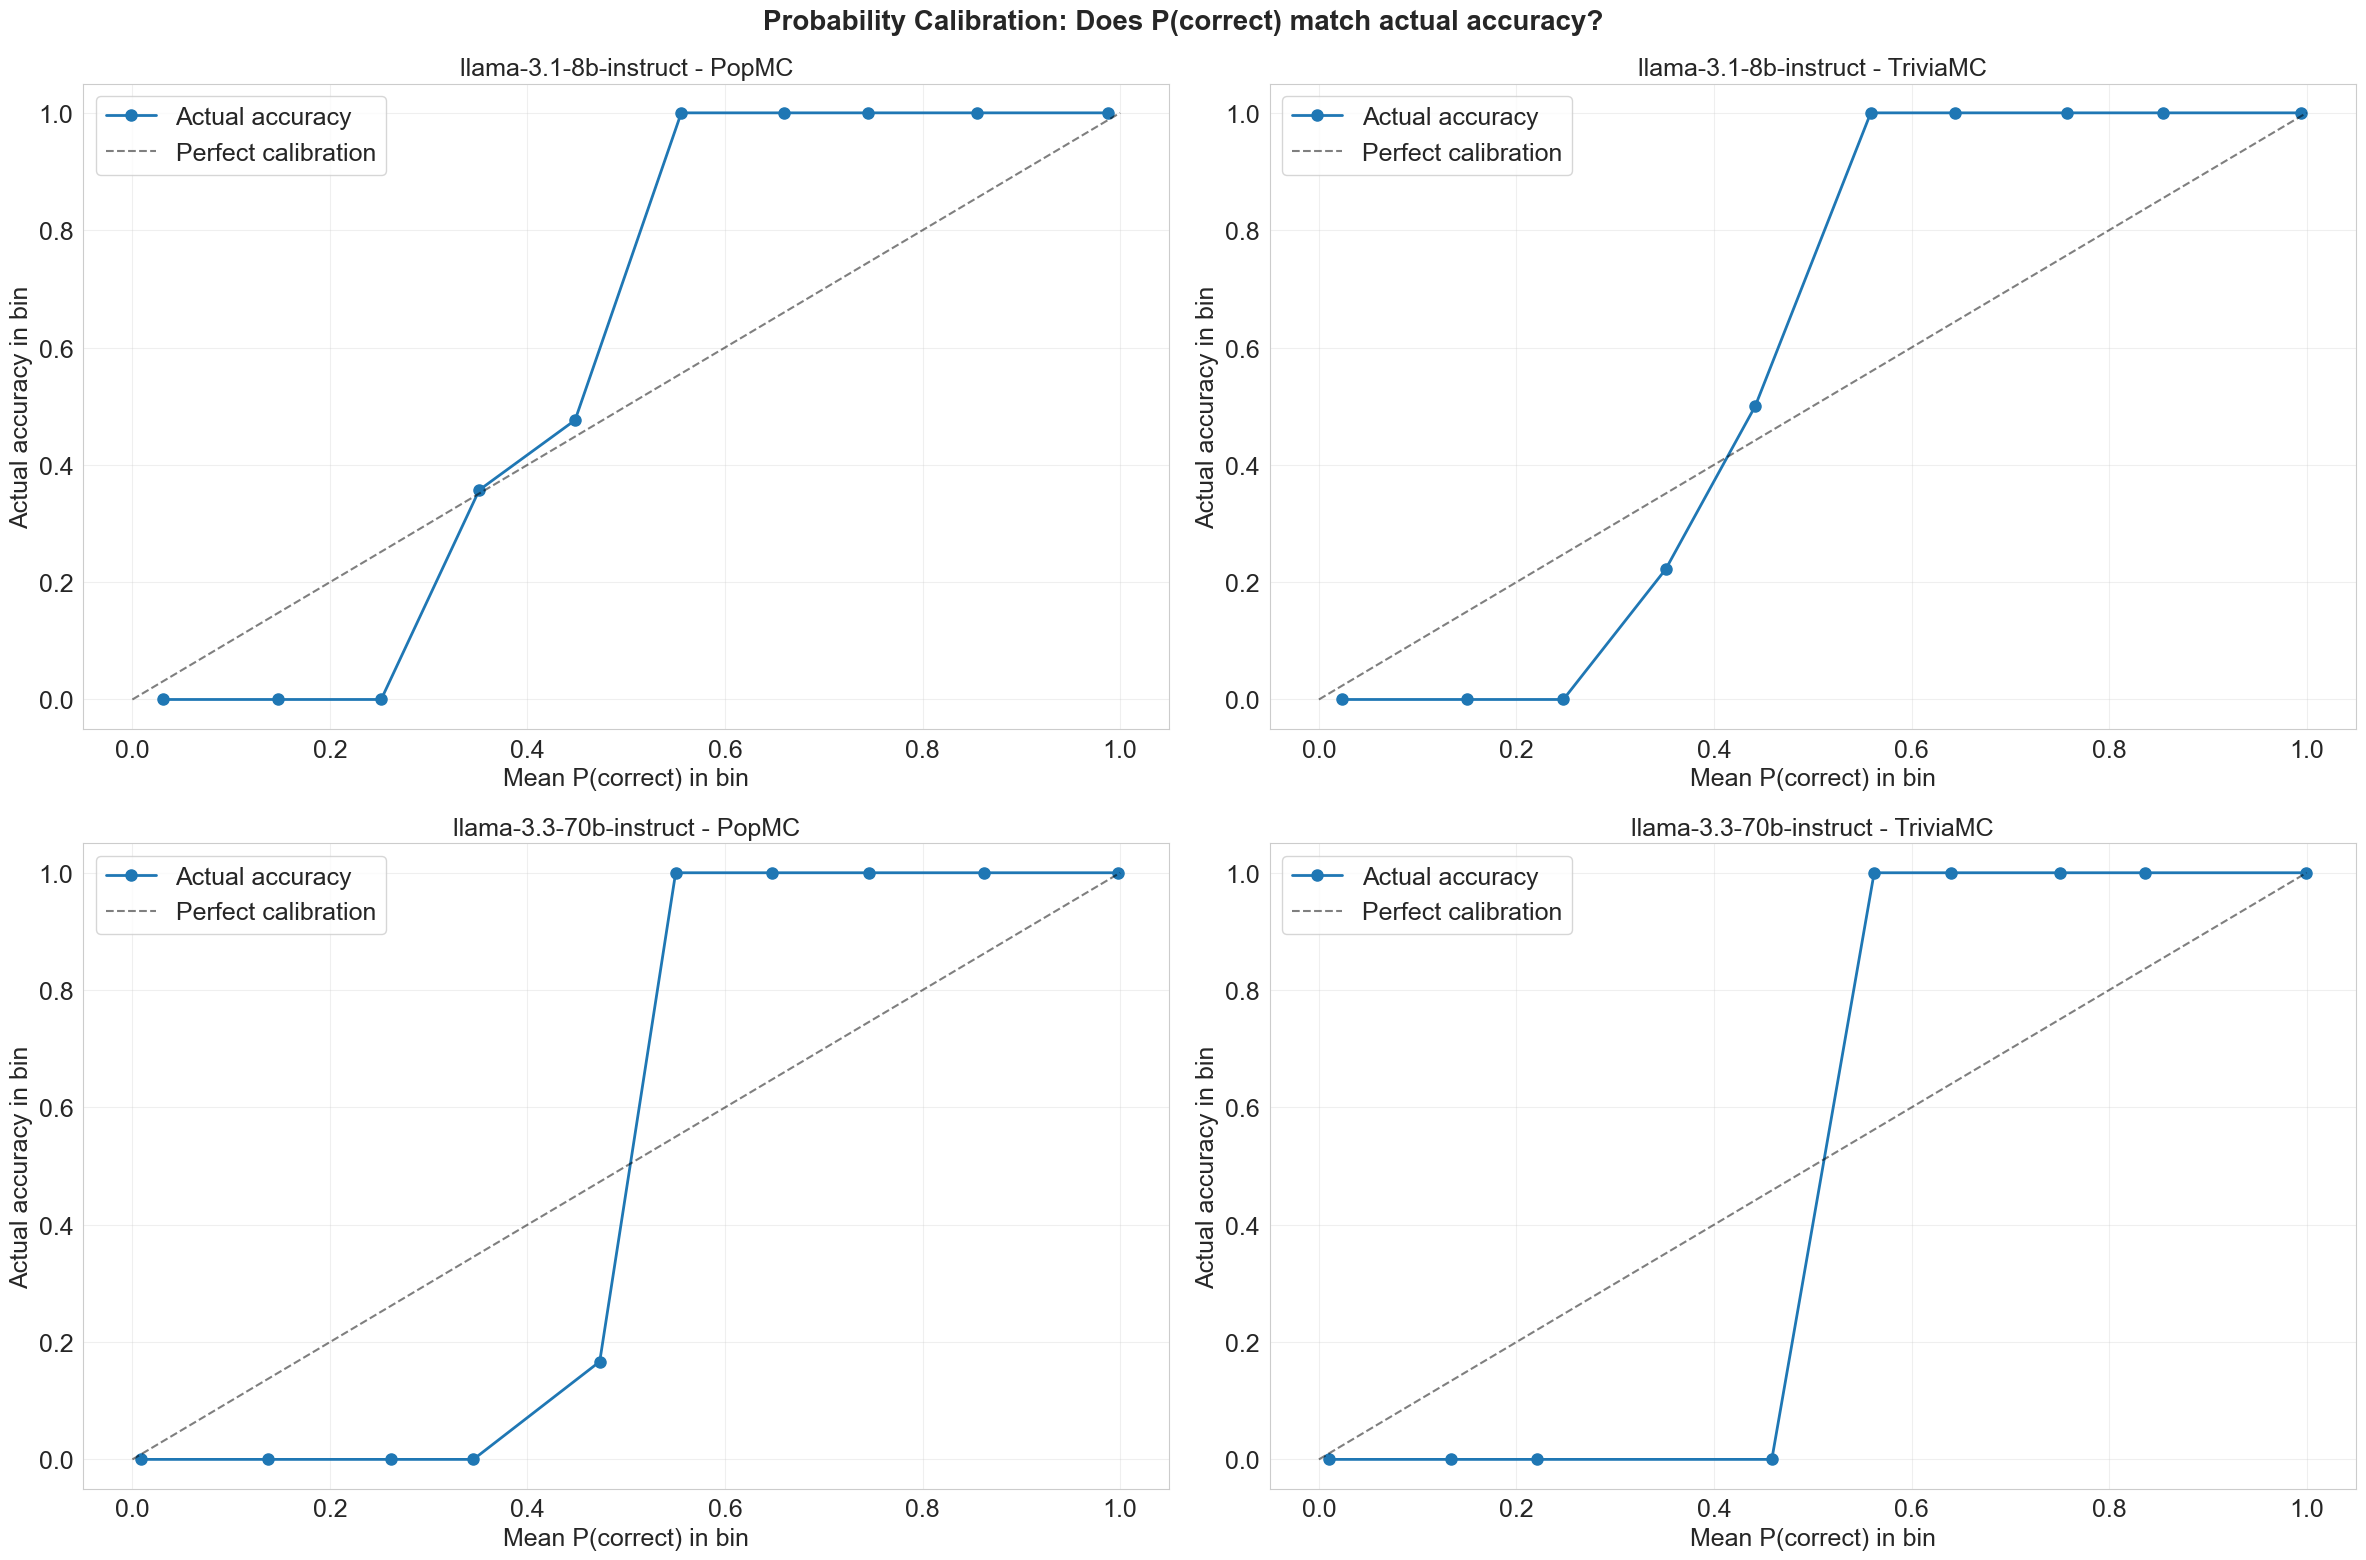

In [ ]:
# Probability calibration - side by side
n_combos = len(all_dfs)
if n_combos > 0:
    n_cols = min(2, n_combos)
    n_rows = math.ceil(n_combos / n_cols)
    
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(12 * n_cols, 8 * n_rows))
    if n_combos == 1:
        axes = [axes]
    elif n_rows == 1:
        axes = axes if isinstance(axes, np.ndarray) else [axes]
    else:
        axes = axes.flatten()
    
    fig.suptitle('Probability Calibration: Does P(correct) match actual accuracy?', 
                 fontsize=FONT_SIZE + 2, fontweight='bold')
    
    for idx, (key, df) in enumerate(all_dfs.items()):
        ax = axes[idx] if n_combos > 1 else axes[0]
        model, test = key.split('_', 1) if '_' in key else (key, '')
        
        df['prob_correct_bin'] = pd.cut(df['prob_correct'], bins=10, labels=False)
        calibration = df.groupby('prob_correct_bin').agg({
            'is_correct': 'mean',
            'prob_correct': 'mean'
        }).reset_index()
        
        ax.plot(calibration['prob_correct'], calibration['is_correct'], 
                marker='o', linewidth=2, markersize=8, label='Actual accuracy')
        ax.plot([0, 1], [0, 1], 'k--', alpha=0.5, label='Perfect calibration')
        ax.set_xlabel('Mean P(correct) in bin')
        ax.set_ylabel('Actual accuracy in bin')
        ax.set_title(f'{model} - {test}')
        ax.legend()
        ax.grid(True, alpha=0.3)
    
    for idx in range(n_combos, len(axes)):
        axes[idx].set_visible(False)
    
    plt.tight_layout()
    plt.show()


In [15]:
# Summary statistics table for all combinations
print("=" * 80)
print("SUMMARY STATISTICS - All Model/Test Combinations")
print("=" * 80)

all_summary_stats = []
for key, df in all_dfs.items():
    model, test = key.split('_', 1) if '_' in key else (key, '')
    
    summary_stats = {
        'Model': model,
        'Test': test,
        'Overall Accuracy': f"{df['is_correct'].mean():.3f}",
        'Mean P(correct)': f"{df['prob_correct'].mean():.3f}",
        'Mean P(chosen)': f"{df['prob_chosen'].mean():.3f}",
        'Mean Entropy': f"{df['entropy'].mean():.3f}",
        '% Correct rank #1': f"{(df['correct_rank'] == 1).mean() * 100:.1f}%",
        '% Correct in top 2': f"{(df['correct_rank'] <= 2).mean() * 100:.1f}%",
        'P(correct)|correct': f"{df[df['is_correct']]['prob_correct'].mean():.3f}",
        'P(correct)|incorrect': f"{df[~df['is_correct']]['prob_correct'].mean():.3f}",
        'P(chosen)|correct': f"{df[df['is_correct']]['prob_chosen'].mean():.3f}",
        'P(chosen)|incorrect': f"{df[~df['is_correct']]['prob_chosen'].mean():.3f}",
    }
    all_summary_stats.append(summary_stats)

summary_df = pd.DataFrame(all_summary_stats)
print("\n" + summary_df.to_string(index=False))


SUMMARY STATISTICS - All Model/Test Combinations

                 Model     Test Overall Accuracy Mean P(correct) Mean P(chosen) Mean Entropy % Correct rank #1 % Correct in top 2 P(correct)|correct P(correct)|incorrect P(chosen)|correct P(chosen)|incorrect
 llama-3.1-8b-instruct    PopMC            0.614           0.598          0.826        0.641             61.4%              80.8%              0.895                0.125             0.895               0.715
 llama-3.1-8b-instruct TriviaMC            0.772           0.758          0.915        0.318             77.2%              86.4%              0.955                0.093             0.955               0.780
llama-3.3-70b-instruct    PopMC            0.736           0.738          0.958        0.145             73.6%              88.8%              0.981                0.060             0.981               0.894
llama-3.3-70b-instruct TriviaMC            0.895           0.896          0.982        0.060             89.5%        

POINT-BISERIAL CORRELATION: max_prob vs is_correct

llama-3.1-8b-instruct - PopMC:
  Point-biserial correlation (r): 0.4323
  p-value: 3.4424e-24
  N: 500

llama-3.1-8b-instruct - TriviaMC:
  Point-biserial correlation (r): 0.4669
  p-value: 1.9705e-28
  N: 500

llama-3.3-70b-instruct - PopMC:
  Point-biserial correlation (r): 0.3488
  p-value: 9.5455e-16
  N: 500

llama-3.3-70b-instruct - TriviaMC:
  Point-biserial correlation (r): 0.4448
  p-value: 2.0325e-25
  N: 495

Summary Table:
                 Model     Test Correlation (r)    p-value   N
 llama-3.1-8b-instruct    PopMC          0.4323 3.4424e-24 500
 llama-3.1-8b-instruct TriviaMC          0.4669 1.9705e-28 500
llama-3.3-70b-instruct    PopMC          0.3488 9.5455e-16 500
llama-3.3-70b-instruct TriviaMC          0.4448 2.0325e-25 495


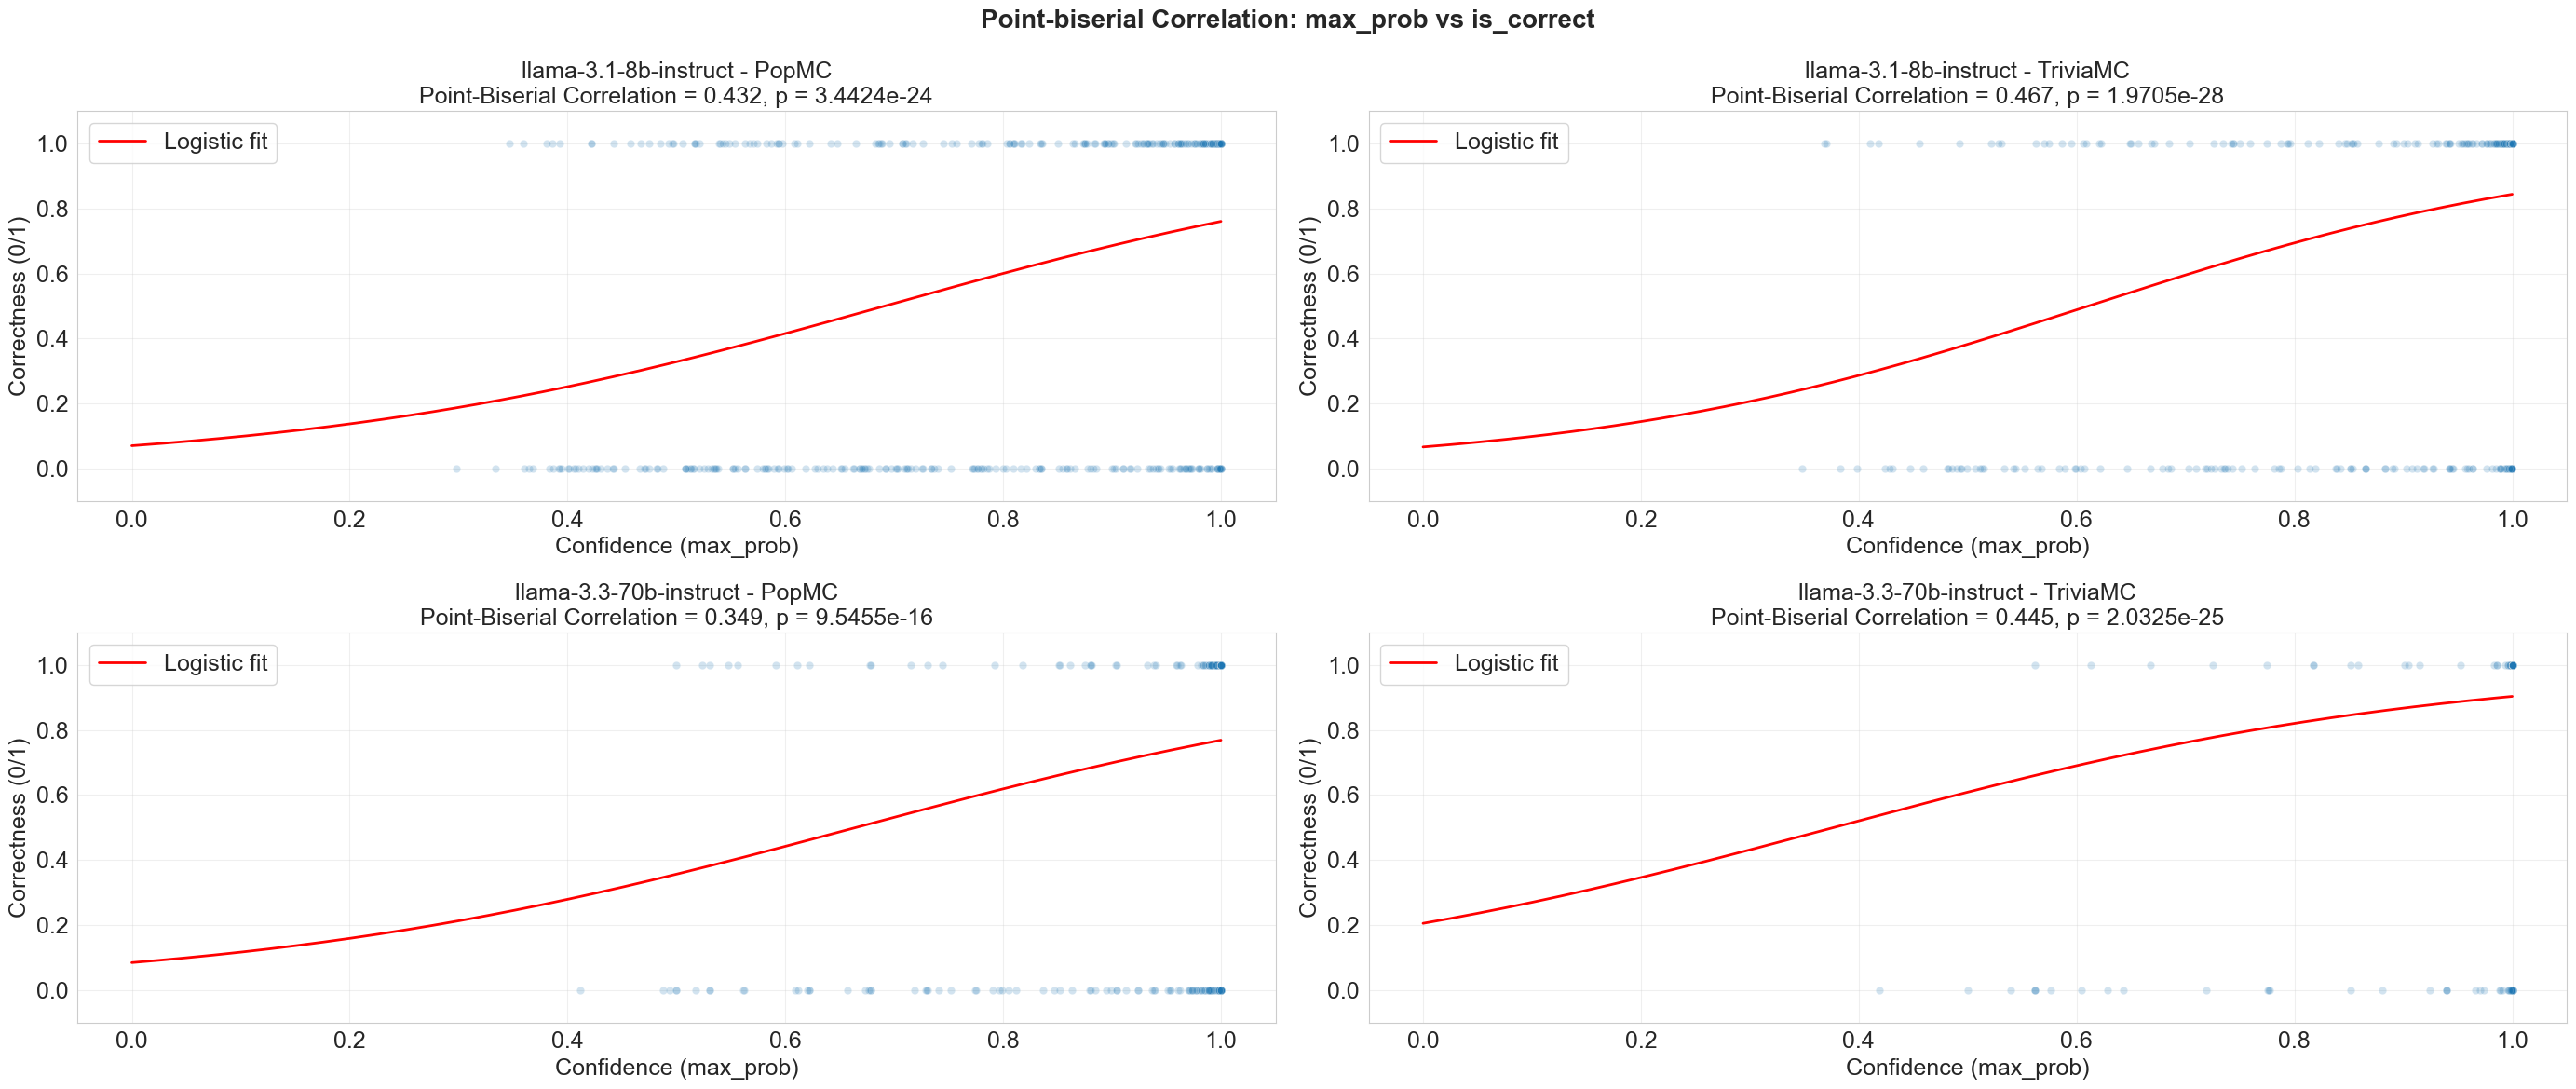

/var/folders/43/_0d5jq894wvgs7d31w0ccq980000gn/T/ipykernel_5241/3829681221.py:108: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bp = ax.boxplot([incorrect_probs, correct_probs],
/var/folders/43/_0d5jq894wvgs7d31w0ccq980000gn/T/ipykernel_5241/3829681221.py:108: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bp = ax.boxplot([incorrect_probs, correct_probs],
/var/folders/43/_0d5jq894wvgs7d31w0ccq980000gn/T/ipykernel_5241/3829681221.py:108: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bp = ax.boxplot([incorrect_probs, correct_probs],
/var/folders/43/_0d5jq894wvgs7d31w0ccq980000gn/T/ipykernel_5241/3829681221.py:108: Matpl

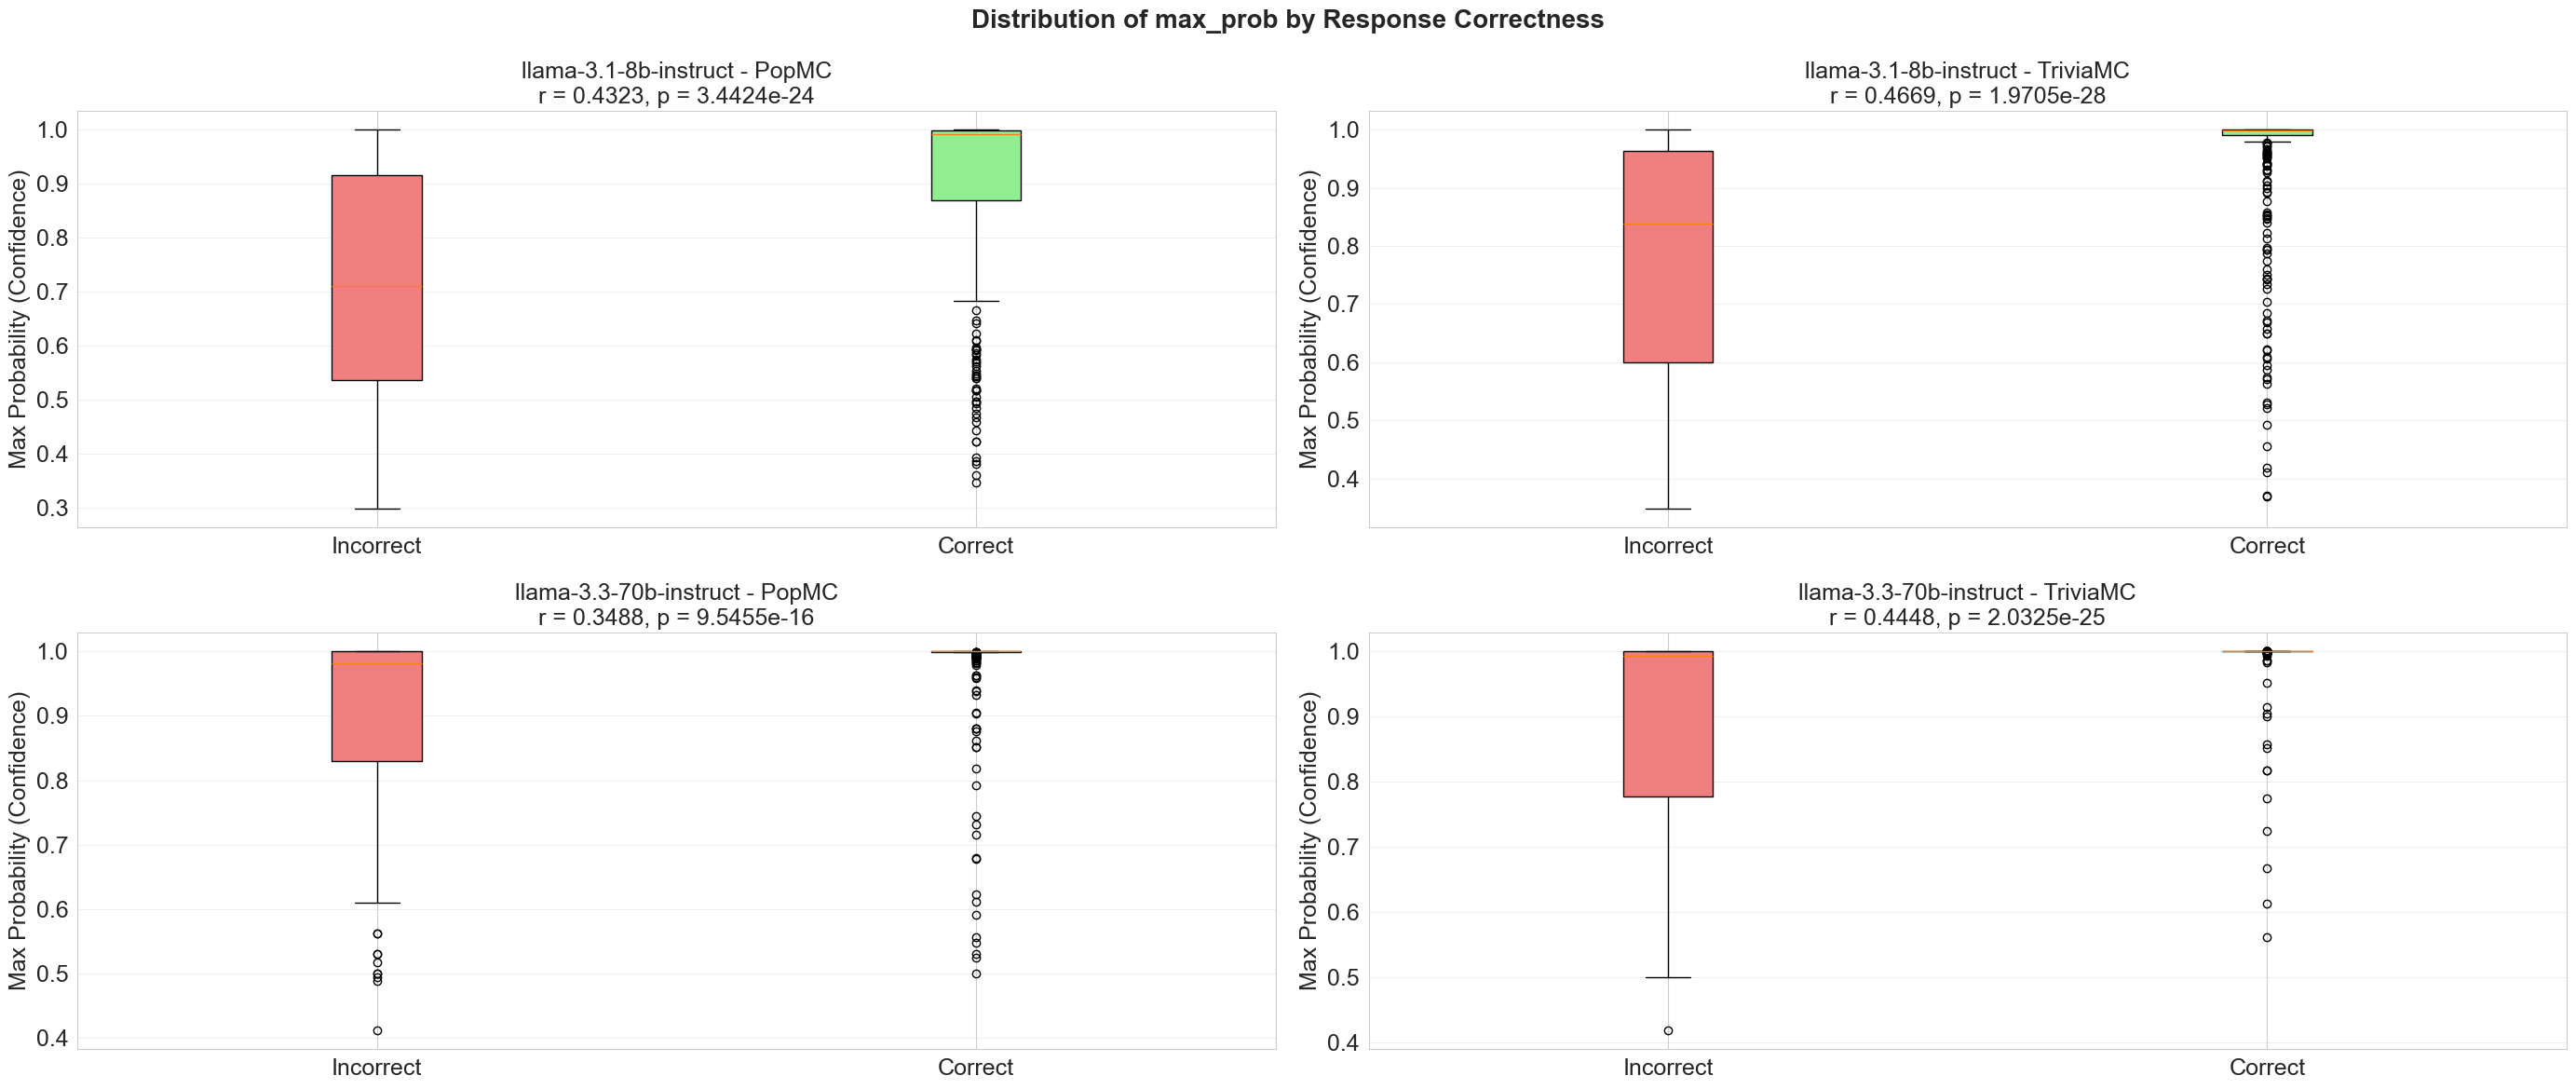

In [ ]:
# Point-biserial correlation: Strength of association between max_prob and is_correct
from scipy.stats import pointbiserialr

print("=" * 80)
print("POINT-BISERIAL CORRELATION: max_prob vs is_correct")
print("=" * 80)

# Compute correlation for each model/test combination
correlation_results = []
for key, df in all_dfs.items():
    model, test = key.split('_', 1) if '_' in key else (key, '')
    
    # Compute point-biserial correlation
    r, p_value = pointbiserialr(df['max_prob'], df['is_correct'])
    
    correlation_results.append({
        'Model': model,
        'Test': test,
        'Correlation (r)': f"{r:.4f}",
        'p-value': f"{p_value:.4e}",
        'N': len(df)
    })
    
    print(f"\n{model} - {test}:")
    print(f"  Point-biserial correlation (r): {r:.4f}")
    print(f"  p-value: {p_value:.4e}")
    print(f"  N: {len(df)}")

corr_df = pd.DataFrame(correlation_results)
print("\n" + "=" * 80)
print("Summary Table:")
print("=" * 80)
print(corr_df.to_string(index=False))

# Create side-by-side plots showing the relationship
n_combos = len(all_dfs)
if n_combos > 0:
    n_cols = min(2, n_combos)
    n_rows = math.ceil(n_combos / n_cols)
    
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(14 * n_cols, 6 * n_rows))
    if n_combos == 1:
        axes = [axes]
    elif n_rows == 1:
        axes = axes if isinstance(axes, np.ndarray) else [axes]
    else:
        axes = axes.flatten()
    
    fig.suptitle('Point-biserial Correlation: max_prob vs is_correct', 
                 fontsize=FONT_SIZE + 2, fontweight='bold')
    
    for idx, (key, df) in enumerate(all_dfs.items()):
        ax = axes[idx] if n_combos > 1 else axes[0]
        model, test = key.split('_', 1) if '_' in key else (key, '')
        
        # Compute correlation
        r, p_value = pointbiserialr(df['max_prob'], df['is_correct'])
        
        # Create scatter plot
        sns.scatterplot(data=df, x='max_prob', y='is_correct', alpha=0.2, ax=ax)
        
        # Fit logistic regression for visualization
        X = df['max_prob'].values.reshape(-1, 1)
        y = df['is_correct'].values
        clf = LogisticRegression().fit(X, y)
        xx = np.linspace(0, 1, 200)
        yy = clf.predict_proba(xx.reshape(-1, 1))[:, 1]
        ax.plot(xx, yy, color='red', linewidth=2, label='Logistic fit')
        
        # Add correlation info to title
        ax.set_xlabel('Confidence (max_prob)')
        ax.set_ylabel('Correctness (0/1)')
        ax.set_title(f'{model} - {test}\nPoint-Biserial Correlation = {r:.3f}, p = {p_value:.4e}')
        ax.set_ylim(-0.1, 1.1)
        ax.legend()
        ax.grid(alpha=0.3)
    
    # Hide unused subplots
    for idx in range(n_combos, len(axes)):
        axes[idx].set_visible(False)
    
    plt.tight_layout()
    plt.show()
    
    # Alternative visualization: Box plot showing distribution of max_prob by correctness
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(14 * n_cols, 6 * n_rows))
    if n_combos == 1:
        axes = [axes]
    elif n_rows == 1:
        axes = axes if isinstance(axes, np.ndarray) else [axes]
    else:
        axes = axes.flatten()
    
    fig.suptitle('Distribution of max_prob by Response Correctness', 
                 fontsize=FONT_SIZE + 2, fontweight='bold')
    
    for idx, (key, df) in enumerate(all_dfs.items()):
        ax = axes[idx] if n_combos > 1 else axes[0]
        model, test = key.split('_', 1) if '_' in key else (key, '')
        
        # Compute correlation
        r, p_value = pointbiserialr(df['max_prob'], df['is_correct'])
        
        # Box plot
        correct_probs = df[df['is_correct']]['max_prob']
        incorrect_probs = df[~df['is_correct']]['max_prob']
        
        bp = ax.boxplot([incorrect_probs, correct_probs], 
                        labels=['Incorrect', 'Correct'],
                        patch_artist=True)
        bp['boxes'][0].set_facecolor('lightcoral')
        bp['boxes'][1].set_facecolor('lightgreen')
        
        ax.set_ylabel('Max Probability (Confidence)')
        ax.set_title(f'{model} - {test}\nr = {r:.4f}, p = {p_value:.4e}')
        ax.grid(True, alpha=0.3, axis='y')
    
    # Hide unused subplots
    for idx in range(n_combos, len(axes)):
        axes[idx].set_visible(False)
    
    plt.tight_layout()
    plt.show()

# Analysis of PopMC obscurity vs confidence and accuracy

POPMC DIFFICULTY ANALYSIS: Using s_pop (subject popularity)
✓ Added s_pop to llama-3.1-8b-instruct_PopMC: 500 questions with s_pop data
✓ Added s_pop to llama-3.3-70b-instruct_PopMC: 500 questions with s_pop data


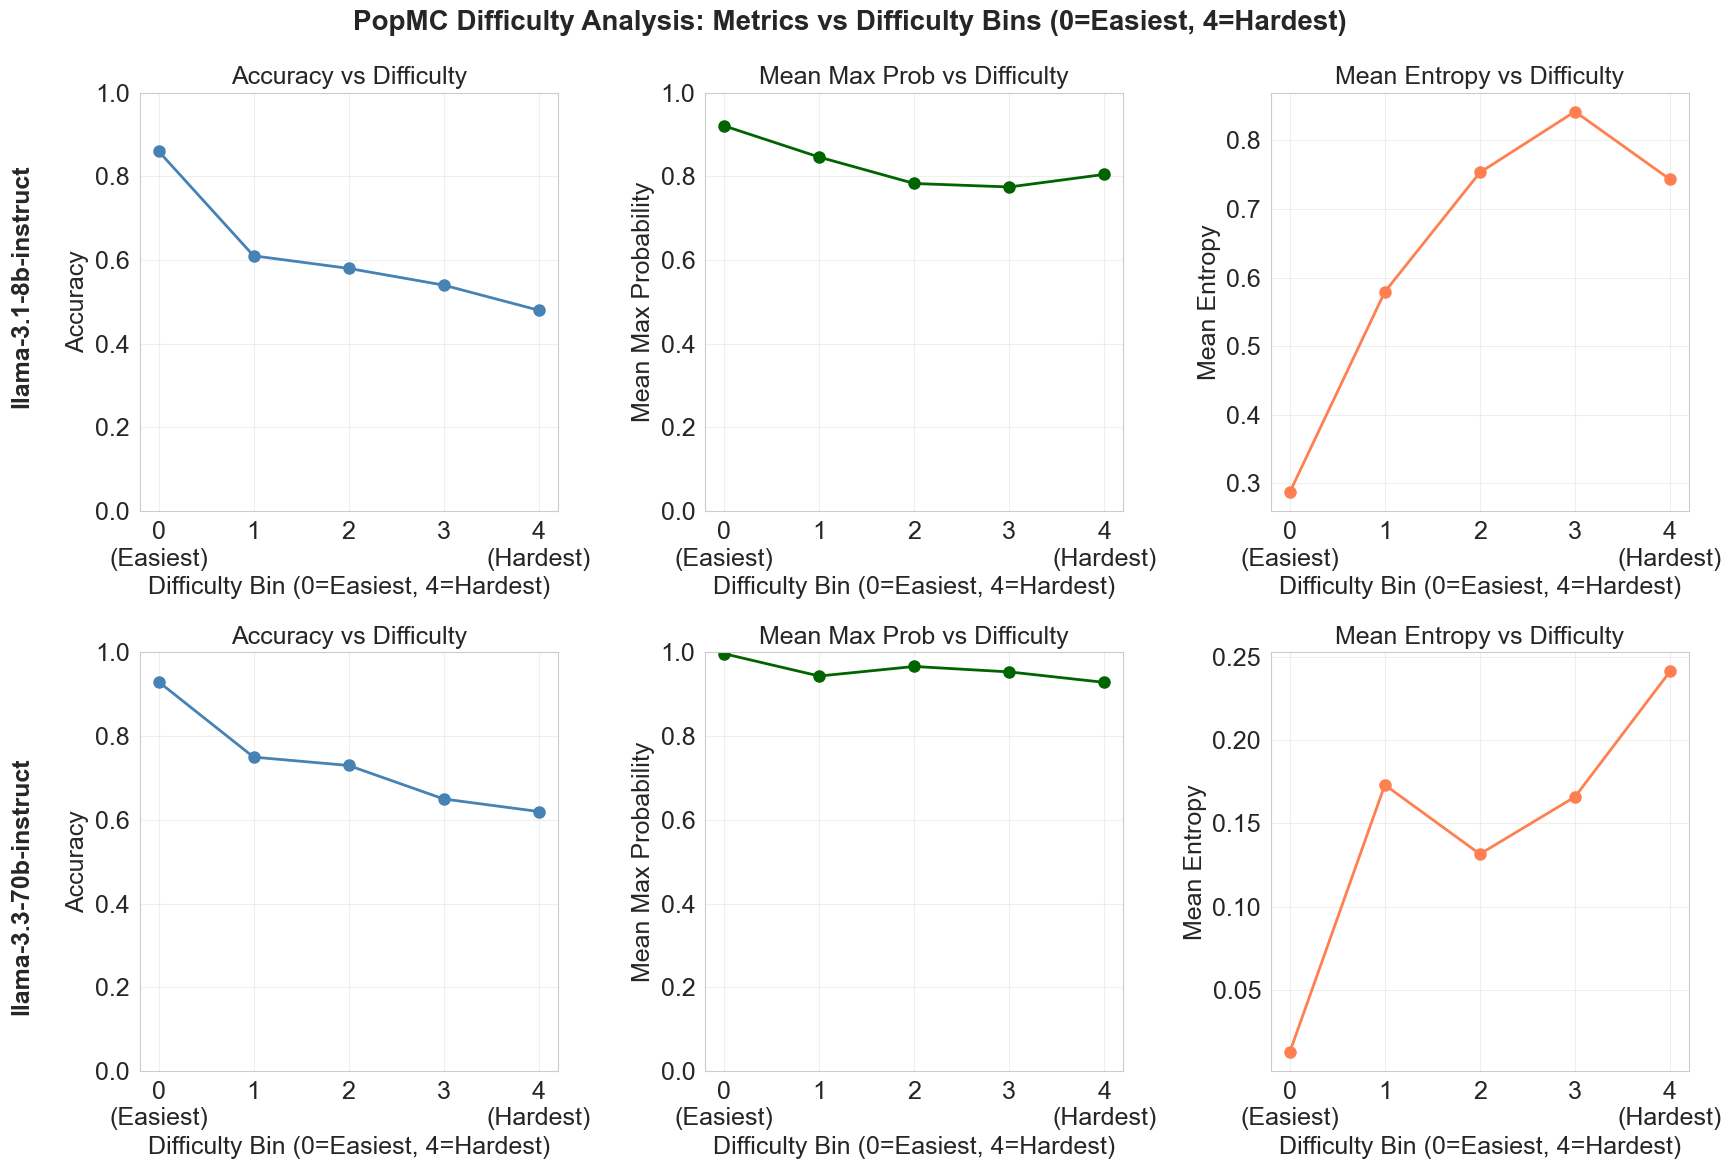


SUMMARY STATISTICS BY DIFFICULTY BIN

llama-3.1-8b-instruct - PopMC:
               is_correct       max_prob entropy     s_pop               
                     mean count     mean    mean      mean    min     max
difficulty_bin                                                           
0                    0.86   100    0.920   0.287  74450.33  13103  671954
1                    0.61   100    0.846   0.579   5249.18   1852   12947
2                    0.58   100    0.783   0.753   1059.50    576    1841
3                    0.54   100    0.774   0.842    331.60    177     562
4                    0.48   100    0.804   0.743     99.82      7     175


llama-3.3-70b-instruct - PopMC:
               is_correct       max_prob entropy     s_pop               
                     mean count     mean    mean      mean    min     max
difficulty_bin                                                           
0                    0.93   100    0.997   0.013  74450.33  13103  671954
1       

In [11]:
# PopMC Difficulty Analysis: Using s_pop (subject popularity) from PopQA
# Only analyze PopMC datasets (TriviaMC does not have s_pop)

print("=" * 80)
print("POPMC DIFFICULTY ANALYSIS: Using s_pop (subject popularity)")
print("=" * 80)

# Filter for PopMC datasets only
popmc_dfs = {key: df for key, df in all_dfs.items() if 'PopMC' in key}

if len(popmc_dfs) == 0:
    print("No PopMC datasets found!")
else:
    # Extract s_pop from original data and add to dataframes
    for key, df in popmc_dfs.items():
        if key in all_data:
            data = all_data[key]
            s_pop_dict = {}
            
            # Extract s_pop for each question
            for q_id, res_info in data.get("results", {}).items():
                question = res_info.get("question", {})
                s_pop = question.get("s_pop")
                if s_pop is not None:
                    s_pop_dict[q_id] = s_pop
            
            # Add s_pop to dataframe
            df['s_pop'] = df['question_id'].map(s_pop_dict)
            
            # Remove rows where s_pop is missing
            df = df.dropna(subset=['s_pop'])
            popmc_dfs[key] = df
            
            print(f"✓ Added s_pop to {key}: {len(df)} questions with s_pop data")
    
    # Now perform difficulty analysis for each PopMC dataset
    n_popmc = len(popmc_dfs)
    if n_popmc > 0:
        # Create layout: n_popmc rows (one per model), 3 columns (one per metric)
        n_rows = n_popmc
        n_cols = 3
        
        # Create subplots: one row per model, three columns for the three metrics
        fig, axes = plt.subplots(n_rows, n_cols, figsize=(18, 6 * n_rows))
        
        # Handle case where there's only one row (axes would be 1D)
        if axes.ndim == 1:
            axes = axes.reshape(1, -1)
        
        fig.suptitle('PopMC Difficulty Analysis: Metrics vs Difficulty Bins (0=Easiest, 4=Hardest)', 
                     fontsize=FONT_SIZE + 2, fontweight='bold')
        
        row_idx = 0
        for key, df in popmc_dfs.items():
            model, test = key.split('_', 1) if '_' in key else (key, '')
            
            # Compute difficulty from s_pop
            df['difficulty'] = -np.log1p(df['s_pop'])
            
            # Create quantile-based difficulty bins (5 bins: 0=easiest, 4=hardest)
            df['difficulty_bin'] = pd.qcut(df['difficulty'], q=5, labels=False)
            
            # Aggregate by difficulty bin
            bin_stats = df.groupby('difficulty_bin').agg({
                'is_correct': 'mean',  # accuracy
                'max_prob': 'mean',    # mean max_prob
                'entropy': 'mean'      # mean entropy
            }).reset_index()
            
            # Plot 1: Accuracy vs difficulty_bin (row_idx, 0)
            ax1 = axes[row_idx, 0]
            ax1.plot(bin_stats['difficulty_bin'], bin_stats['is_correct'], 
                    marker='o', linewidth=2, markersize=8, color='steelblue')
            ax1.set_xlabel('Difficulty Bin (0=Easiest, 4=Hardest)')
            ax1.set_ylabel('Accuracy')
            ax1.set_title('Accuracy vs Difficulty')
            ax1.set_xticks([0, 1, 2, 3, 4])
            ax1.set_xticklabels(['0\n(Easiest)', '1', '2', '3', '4\n(Hardest)'])
            ax1.grid(True, alpha=0.3)
            ax1.set_ylim(0, 1)
            
            # Plot 2: Mean max_prob vs difficulty_bin (row_idx, 1)
            ax2 = axes[row_idx, 1]
            ax2.plot(bin_stats['difficulty_bin'], bin_stats['max_prob'], 
                    marker='o', linewidth=2, markersize=8, color='darkgreen')
            ax2.set_xlabel('Difficulty Bin (0=Easiest, 4=Hardest)')
            ax2.set_ylabel('Mean Max Probability')
            ax2.set_title('Mean Max Prob vs Difficulty')
            ax2.set_xticks([0, 1, 2, 3, 4])
            ax2.set_xticklabels(['0\n(Easiest)', '1', '2', '3', '4\n(Hardest)'])
            ax2.grid(True, alpha=0.3)
            ax2.set_ylim(0, 1)
            
            # Plot 3: Mean entropy vs difficulty_bin (row_idx, 2)
            ax3 = axes[row_idx, 2]
            ax3.plot(bin_stats['difficulty_bin'], bin_stats['entropy'], 
                    marker='o', linewidth=2, markersize=8, color='coral')
            ax3.set_xlabel('Difficulty Bin (0=Easiest, 4=Hardest)')
            ax3.set_ylabel('Mean Entropy')
            ax3.set_title('Mean Entropy vs Difficulty')
            ax3.set_xticks([0, 1, 2, 3, 4])
            ax3.set_xticklabels(['0\n(Easiest)', '1', '2', '3', '4\n(Hardest)'])
            ax3.grid(True, alpha=0.3)
            
            row_idx += 1
        
        # Add model name labels on the left side of each row, rotated 90 degrees
        # Do this after creating all plots but before tight_layout
        row_idx = 0
        for key, df in popmc_dfs.items():
            model, test = key.split('_', 1) if '_' in key else (key, '')
            
            # Calculate the vertical position (0 = bottom, 1 = top)
            # For n_rows, row_idx 0 is at the top, row_idx n_rows-1 is at the bottom
            # We want to center it in the row's vertical space
            row_height = 1.0 / n_rows
            row_center_y = 1.0 - (row_idx + 0.5) * row_height
            
            # Add text at the left edge, rotated 90 degrees, bold
            # Position at x=0.04 to be closer to the plots but with a small gap
            fig.text(0.04, row_center_y, model, rotation=90, 
                    ha='center', va='center', fontsize=FONT_SIZE, 
                    fontweight='bold')
            
            row_idx += 1
        
        # Adjust layout to make room for the labels on the left (reduced margin)
        plt.tight_layout(rect=[0.05, 0, 1, 1])
        plt.show()
        
        # Print summary statistics
        print("\n" + "=" * 80)
        print("SUMMARY STATISTICS BY DIFFICULTY BIN")
        print("=" * 80)
        
        for key, df in popmc_dfs.items():
            model, test = key.split('_', 1) if '_' in key else (key, '')
            print(f"\n{model} - {test}:")
            
            bin_summary = df.groupby('difficulty_bin').agg({
                'is_correct': ['mean', 'count'],
                'max_prob': 'mean',
                'entropy': 'mean',
                's_pop': ['mean', 'min', 'max']
            }).round(3)
            
            print(bin_summary.to_string())
            print()
    else:
        print("No PopMC datasets with s_pop data found!")


In [5]:
# Logistic Regression: Predicting Correctness from Obscurity (s_pop) and Confidence (max_prob)
# Only analyze PopMC datasets (TriviaMC does not have s_pop)

print("=" * 80)
print("LOGISTIC REGRESSION: Predicting Correctness from Obscurity and Confidence")
print("=" * 80)
print("Features:")
print("  - Obscurity: s_pop (subject popularity, lower = more obscure)")
print("  - Confidence: max_prob (maximum probability)")
print("=" * 80)

# Filter for PopMC datasets only (they have s_pop)
popmc_dfs = {key: df for key, df in all_dfs.items() if 'PopMC' in key}

if len(popmc_dfs) == 0:
    print("No PopMC datasets found!")
else:
    # Extract s_pop from original data and add to dataframes (if not already added)
    for key, df in popmc_dfs.items():
        if 's_pop' not in df.columns:
            if key in all_data:
                data = all_data[key]
                s_pop_dict = {}
                
                # Extract s_pop for each question
                for q_id, res_info in data.get("results", {}).items():
                    question = res_info.get("question", {})
                    s_pop = question.get("s_pop")
                    if s_pop is not None:
                        s_pop_dict[q_id] = s_pop
                
                # Add s_pop to dataframe
                df['s_pop'] = df['question_id'].map(s_pop_dict)
                popmc_dfs[key] = df
        
        # Remove rows where s_pop is missing
        df = popmc_dfs[key]
        df = df.dropna(subset=['s_pop', 'max_prob', 'is_correct'])
        popmc_dfs[key] = df
    
    # Perform logistic regression for each PopMC dataset
    regression_results = []
    
    for key, df in popmc_dfs.items():
        model, test = key.split('_', 1) if '_' in key else (key, '')
        
        print(f"\n{'=' * 80}")
        print(f"{model} - {test}")
        print(f"{'=' * 80}")
        print(f"Sample size: {len(df)} questions")
        
        # Prepare features: s_pop (obscurity) and max_prob (confidence)
        X = df[['s_pop', 'max_prob']]
        y = df['is_correct']
        
        # Fit logistic regression
        clf = LogisticRegression().fit(X, y)
        
        # Get coefficients
        coef_s_pop = clf.coef_[0][0]
        coef_max_prob = clf.coef_[0][1]
        intercept = clf.intercept_[0]
        
        # Predictions and probabilities
        y_pred = clf.predict(X)
        y_proba = clf.predict_proba(X)[:, 1]
        
        # Calculate metrics
        accuracy = (y_pred == y).mean()
        auc = roc_auc_score(y, y_proba)
        
        # Point-biserial correlations for individual features
        r_s_pop, p_s_pop = pointbiserialr(df['s_pop'], df['is_correct'])
        r_max_prob, p_max_prob = pointbiserialr(df['max_prob'], df['is_correct'])
        
        # Store results
        regression_results.append({
            'Model': model,
            'Test': test,
            'N': len(df),
            'Intercept': f"{intercept:.4f}",
            'Coefficient (s_pop)': f"{coef_s_pop:.6f}",
            'Coefficient (max_prob)': f"{coef_max_prob:.4f}",
            'Accuracy': f"{accuracy:.4f}",
            'AUC': f"{auc:.4f}",
            'r(s_pop)': f"{r_s_pop:.4f}",
            'r(max_prob)': f"{r_max_prob:.4f}"
        })
        
        # Print detailed results
        print(f"\nLogistic Regression Results:")
        print(f"  Intercept: {intercept:.4f}")
        print(f"  Coefficient for s_pop (obscurity): {coef_s_pop:.6f}")
        print(f"    → Interpretation: For each unit increase in s_pop (less obscure),")
        print(f"       log-odds of correctness increase by {coef_s_pop:.6f}")
        print(f"  Coefficient for max_prob (confidence): {coef_max_prob:.4f}")
        print(f"    → Interpretation: For each 0.01 increase in max_prob,")
        print(f"       log-odds of correctness increase by {coef_max_prob * 0.01:.6f}")
        
        print(f"\nModel Performance:")
        print(f"  Accuracy: {accuracy:.4f} ({accuracy * 100:.2f}%)")
        print(f"  AUC-ROC: {auc:.4f}")
        
        print(f"\nIndividual Feature Correlations:")
        print(f"  s_pop vs correctness: r = {r_s_pop:.4f}, p = {p_s_pop:.4e}")
        print(f"  max_prob vs correctness: r = {r_max_prob:.4f}, p = {p_max_prob:.4e}")
        
        # Odds ratios
        odds_ratio_s_pop = np.exp(coef_s_pop)
        odds_ratio_max_prob = np.exp(coef_max_prob)
        print(f"\nOdds Ratios:")
        print(f"  s_pop: {odds_ratio_s_pop:.6f} (per unit increase)")
        print(f"  max_prob: {odds_ratio_max_prob:.4f} (per unit increase)")
        print(f"    → For max_prob: {odds_ratio_max_prob:.4f}x odds of being correct per 1.0 increase")
        print(f"    → For max_prob: {np.exp(coef_max_prob * 0.1):.4f}x odds per 0.1 increase")
    
    # Summary table
    print("\n" + "=" * 80)
    print("SUMMARY TABLE: Logistic Regression Results")
    print("=" * 80)
    results_df = pd.DataFrame(regression_results)
    print(results_df.to_string(index=False))
    
    # Visualizations
    n_popmc = len(popmc_dfs)
    if n_popmc > 0:
        # Create visualization: Scatter plots with logistic regression decision boundary
        fig, axes = plt.subplots(n_popmc, 2, figsize=(16, 8 * n_popmc))
        if n_popmc == 1:
            axes = axes.reshape(1, -1)
        
        fig.suptitle('Logistic Regression: Correctness vs Obscurity (s_pop) and Confidence (max_prob)', 
                     fontsize=FONT_SIZE + 2, fontweight='bold')
        
        row_idx = 0
        for key, df in popmc_dfs.items():
            model, test = key.split('_', 1) if '_' in key else (key, '')
            
            # Prepare features
            X = df[['s_pop', 'max_prob']]
            y = df['is_correct']
            
            # Fit logistic regression
            clf = LogisticRegression().fit(X, y)
            
            # Plot 1: s_pop vs is_correct with logistic curve
            ax1 = axes[row_idx, 0]
            correct_mask = df['is_correct']
            ax1.scatter(df[correct_mask]['s_pop'], df[correct_mask]['is_correct'] + np.random.normal(0, 0.02, len(df[correct_mask])), 
                       alpha=0.3, color='green', s=20, label='Correct')
            ax1.scatter(df[~correct_mask]['s_pop'], df[~correct_mask]['is_correct'] + np.random.normal(0, 0.02, len(df[~correct_mask])), 
                       alpha=0.3, color='red', s=20, label='Incorrect')
            
            # Plot logistic curve for s_pop (holding max_prob at mean)
            mean_max_prob = df['max_prob'].mean()
            s_pop_range = np.linspace(df['s_pop'].min(), df['s_pop'].max(), 200)
            X_curve = np.column_stack([s_pop_range, np.full(200, mean_max_prob)])
            y_curve = clf.predict_proba(X_curve)[:, 1]
            ax1.plot(s_pop_range, y_curve, 'b-', linewidth=2, label='Logistic fit (max_prob at mean)')
            
            ax1.set_xlabel('Obscurity (s_pop, lower = more obscure)')
            ax1.set_ylabel('Correctness (0/1)')
            ax1.set_title(f'{model} - {test}\nCoefficient: {clf.coef_[0][0]:.6f}')
            ax1.set_ylim(-0.1, 1.1)
            ax1.legend()
            ax1.grid(True, alpha=0.3)
            
            # Plot 2: max_prob vs is_correct with logistic curve
            ax2 = axes[row_idx, 1]
            ax2.scatter(df[correct_mask]['max_prob'], df[correct_mask]['is_correct'] + np.random.normal(0, 0.02, len(df[correct_mask])), 
                       alpha=0.3, color='green', s=20, label='Correct')
            ax2.scatter(df[~correct_mask]['max_prob'], df[~correct_mask]['is_correct'] + np.random.normal(0, 0.02, len(df[~correct_mask])), 
                       alpha=0.3, color='red', s=20, label='Incorrect')
            
            # Plot logistic curve for max_prob (holding s_pop at mean)
            mean_s_pop = df['s_pop'].mean()
            max_prob_range = np.linspace(df['max_prob'].min(), df['max_prob'].max(), 200)
            X_curve = np.column_stack([np.full(200, mean_s_pop), max_prob_range])
            y_curve = clf.predict_proba(X_curve)[:, 1]
            ax2.plot(max_prob_range, y_curve, 'b-', linewidth=2, label='Logistic fit (s_pop at mean)')
            
            ax2.set_xlabel('Confidence (max_prob)')
            ax2.set_ylabel('Correctness (0/1)')
            ax2.set_title(f'{model} - {test}\nCoefficient: {clf.coef_[0][1]:.4f}')
            ax2.set_ylim(-0.1, 1.1)
            ax2.legend()
            ax2.grid(True, alpha=0.3)
            
            row_idx += 1
        
        # Add model name labels on the left side
        row_idx = 0
        for key, df in popmc_dfs.items():
            model, test = key.split('_', 1) if '_' in key else (key, '')
            row_height = 1.0 / n_popmc
            row_center_y = 1.0 - (row_idx + 0.5) * row_height
            fig.text(0.02, row_center_y, model, rotation=90, 
                    ha='center', va='center', fontsize=FONT_SIZE, 
                    fontweight='bold')
            row_idx += 1
        
        plt.tight_layout(rect=[0.04, 0, 1, 1])
        plt.show()
        
        # 3D visualization: s_pop vs max_prob vs correctness
        if n_popmc <= 2:  # Only show 3D plots if not too many models
            fig = plt.figure(figsize=(16, 8 * n_popmc))
            
            row_idx = 0
            for key, df in popmc_dfs.items():
                model, test = key.split('_', 1) if '_' in key else (key, '')
                
                ax = fig.add_subplot(n_popmc, 1, row_idx + 1, projection='3d')
                
                # Scatter plot colored by correctness
                correct_mask = df['is_correct']
                ax.scatter(df[correct_mask]['s_pop'], df[correct_mask]['max_prob'], 
                          df[correct_mask]['is_correct'], alpha=0.5, color='green', 
                          s=20, label='Correct')
                ax.scatter(df[~correct_mask]['s_pop'], df[~correct_mask]['max_prob'], 
                          df[~correct_mask]['is_correct'], alpha=0.5, color='red', 
                          s=20, label='Incorrect')
                
                # Create decision surface
                X = df[['s_pop', 'max_prob']]
                y = df['is_correct']
                clf = LogisticRegression().fit(X, y)
                
                s_pop_range = np.linspace(df['s_pop'].min(), df['s_pop'].max(), 50)
                max_prob_range = np.linspace(df['max_prob'].min(), df['max_prob'].max(), 50)
                S_pop, M_prob = np.meshgrid(s_pop_range, max_prob_range)
                
                X_surface = np.column_stack([S_pop.ravel(), M_prob.ravel()])
                Z_surface = clf.predict_proba(X_surface)[:, 1].reshape(S_pop.shape)
                
                ax.plot_surface(S_pop, M_prob, Z_surface, alpha=0.3, cmap='viridis')
                
                ax.set_xlabel('Obscurity (s_pop)')
                ax.set_ylabel('Confidence (max_prob)')
                ax.set_zlabel('P(Correct)')
                ax.set_title(f'{model} - {test}: Logistic Regression Decision Surface')
                ax.legend()
                
                row_idx += 1
            
            plt.tight_layout()
            plt.show()


LOGISTIC REGRESSION: Predicting Correctness from Obscurity and Confidence
Features:
  - Obscurity: s_pop (subject popularity, lower = more obscure)
  - Confidence: max_prob (maximum probability)


NameError: name 'all_dfs' is not defined